# Análisis de un Ecommerce del sector cosméticos

Exploración de los datos transaccionales del comercio online tras su gran evolución durante los últimos meses, a fin de implementar acciones CRO personalizadas a su situación en base a dicho análisis.


Entre las principales medidas a tomar serán:

* Incrementen visitas, conversiones y ticket medio, y por tanto incrementar la facturación global del ecommerce.

* Crear activos analíticos avanzados como una segmentación RFM y un sistema de recomendación que impulsen la consecución del objetivo.


# Importación e inspección

In [1]:
# Importacion de librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
#Estilos para entregables 
sns.set_theme(style="whitegrid")

#Automcompletar rápido
%config IPCompleter.greedy = True

#Formato de display
pd.options.display.float_format = '{:15.2f}'.format


## Carga de Datos

Los datos son proporcionados de la base de datos SQLITE del ecommerce 



In [13]:
# Importamos libreria para BBDD y establecemos coneccion

import sqlalchemy as sa
con = sa.create_engine('sqlite:///00_Datos/ecommerce.db')

In [14]:
# Inspeccionamos tablas para ver que contienen
from sqlalchemy import inspect
insp = inspect(con)
tablas = insp.get_table_names()
tablas

['2019-Dec', '2019-Nov', '2019-Oct', '2020-Feb', '2020-Jan']

In [15]:
# Una vez visualizadas las tablas, valoramos que se pueden hacer cargas de datasets de cada mes

oct = pd.read_sql('2019-Oct', con)
nov = pd.read_sql('2019-Nov', con)
dic = pd.read_sql('2019-Dec', con)
ene = pd.read_sql('2020-Jan', con)
feb = pd.read_sql('2020-Feb', con)

## Integración de datos

Al tener los datos cargados por meses, pasaremos ahora a integrarlos en un solo Dataframe de forma cronológica

In [16]:
df = pd.concat([oct, nov, dic, ene, feb], axis = 0)
df

,index,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,68,2019-10-01 00:01:46 UTC,view,5843665,1487580005092295511,None,f.o.x,9.44,462033176,a18e0999-61a1-4218-8f8f-61ec1d375361
1,72,2019-10-01 00:01:55 UTC,cart,5868461,1487580013069861041,None,italwax,3.57,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1
2,95,2019-10-01 00:02:50 UTC,view,5877456,1487580006300255120,None,jessnail,122.22,527418424,86e77869-afbc-4dff-9aa2-6b7dd8c90770
3,122,2019-10-01 00:03:41 UTC,view,5649270,1487580013749338323,None,concept,6.19,555448072,b5f72ceb-0730-44de-a932-d16db62390df
4,124,2019-10-01 00:03:44 UTC,view,18082,1487580005411062629,None,cnd,16.03,552006247,2d8f304b-de45-4e59-8f40-50c603843fe5
...,...,...,...,...,...,...,...,...,...,...
429785,4156660,2020-02-29 23:58:49 UTC,cart,5815662,1487580006317032337,None,None,0.92,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429786,4156663,2020-02-29 23:58:57 UTC,view,5815665,1487580006317032337,None,None,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429787,4156668,2020-02-29 23:59:05 UTC,cart,5815665,1487580006317032337,None,None,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429788,4156675,2020-02-29 23:59:28 UTC,view,5817692,1487580010872045658,None,None,0.79,619841242,18af673b-7fb9-4202-a66d-5c855bc0fd2d


# Calidad de Datos

## Tipos de variables

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2095076 entries, 0 to 429789
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   index          int64  
 1   event_time     object 
 2   event_type     object 
 3   product_id     int64  
 4   category_id    int64  
 5   category_code  object 
 6   brand          object 
 7   price          float64
 8   user_id        int64  
 9   user_session   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 175.8+ MB


### Principales observaciones:
* Columna index no nos aporta información, la eliminamos
* Debemos cambiar el tipo de event_time a DateTime
* Podemos pasar los nombres de las variables a Español

In [19]:
# Eliminamos columna Index
df.drop(columns = 'index', inplace = True)

In [20]:
# Cambiamos tipo de event_time

#forma tradicional, aunque tarda demasiado en grandes datasets y no la aplicaré
#df.event_time = pd.to_datetime(df.event_time)

#Truco: si dividimos la cadena de la fecha en sus partes y la volvemos a juntar y después transformamos a datetime especificándole el formato exacto funciona MUCHO más rápido.


# Creamos una funcion para que separe la fecha
# A esta función hay que pasarle la variable fecha y el formato en el que está

def datetime_rapido(dt,formato):

    def divide_fecha(fecha):
        division = fecha.split()
        date = division[0]
        time = division[1]
        cadena = date + ' ' + time
        return cadena

    resultado = pd.to_datetime(dt.apply(lambda x: divide_fecha(x)), format = formato)

    return resultado

In [21]:
# Aplicamos la funcion:

formato = '%Y-%m-%d %H:%M:%S'

df.event_time = datetime_rapido(df.event_time,formato)

In [23]:
# Comprobamos primeros cambios
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2095076 entries, 0 to 429789
Data columns (total 9 columns):
 #   Column         Dtype         
---  ------         -----         
 0   event_time     datetime64[ns]
 1   event_type     object        
 2   product_id     int64         
 3   category_id    int64         
 4   category_code  object        
 5   brand          object        
 6   price          float64       
 7   user_id        int64         
 8   user_session   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(4)
memory usage: 159.8+ MB


In [24]:
# Renombramos variables a Español

df.columns = ['fecha',
              'evento',
              'producto',
              'categoria',
              'categoria_cod',
              'marca',
              'precio',
              'usuario',
              'sesion']
df

,fecha,evento,producto,categoria,categoria_cod,marca,precio,usuario,sesion
0,2019-10-01 00:01:46,view,5843665,1487580005092295511,None,f.o.x,9.44,462033176,a18e0999-61a1-4218-8f8f-61ec1d375361
1,2019-10-01 00:01:55,cart,5868461,1487580013069861041,None,italwax,3.57,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1
2,2019-10-01 00:02:50,view,5877456,1487580006300255120,None,jessnail,122.22,527418424,86e77869-afbc-4dff-9aa2-6b7dd8c90770
3,2019-10-01 00:03:41,view,5649270,1487580013749338323,None,concept,6.19,555448072,b5f72ceb-0730-44de-a932-d16db62390df
4,2019-10-01 00:03:44,view,18082,1487580005411062629,None,cnd,16.03,552006247,2d8f304b-de45-4e59-8f40-50c603843fe5
...,...,...,...,...,...,...,...,...,...
429785,2020-02-29 23:58:49,cart,5815662,1487580006317032337,None,None,0.92,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429786,2020-02-29 23:58:57,view,5815665,1487580006317032337,None,None,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429787,2020-02-29 23:59:05,cart,5815665,1487580006317032337,None,None,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429788,2020-02-29 23:59:28,view,5817692,1487580010872045658,None,None,0.79,619841242,18af673b-7fb9-4202-a66d-5c855bc0fd2d


## Análisis de Nulos

In [27]:
df.isna().sum().sort_values(ascending = False)

categoria_cod    2060411
marca             891646
sesion               506
fecha                  0
evento                 0
producto               0
categoria              0
precio                 0
usuario                0
dtype: int64

**Conclusiones:**

* categoria_cod tiene casi todos los registros a nulo
* marca tiene casi la mitad de los registros a nulo
* hay 500 nulos en sesión

**Acciones:**

* eliminar las variables categoria_cod y marca
* eliminar los nulos de sesión ya que es una variable relevante

In [30]:
df = df.drop(columns = ['categoria_cod','marca']).dropna()
df

,fecha,evento,producto,categoria,precio,usuario,sesion
0,2019-10-01 00:01:46,view,5843665,1487580005092295511,9.44,462033176,a18e0999-61a1-4218-8f8f-61ec1d375361
1,2019-10-01 00:01:55,cart,5868461,1487580013069861041,3.57,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1
2,2019-10-01 00:02:50,view,5877456,1487580006300255120,122.22,527418424,86e77869-afbc-4dff-9aa2-6b7dd8c90770
3,2019-10-01 00:03:41,view,5649270,1487580013749338323,6.19,555448072,b5f72ceb-0730-44de-a932-d16db62390df
4,2019-10-01 00:03:44,view,18082,1487580005411062629,16.03,552006247,2d8f304b-de45-4e59-8f40-50c603843fe5
...,...,...,...,...,...,...,...
429785,2020-02-29 23:58:49,cart,5815662,1487580006317032337,0.92,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429786,2020-02-29 23:58:57,view,5815665,1487580006317032337,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429787,2020-02-29 23:59:05,cart,5815665,1487580006317032337,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429788,2020-02-29 23:59:28,view,5817692,1487580010872045658,0.79,619841242,18af673b-7fb9-4202-a66d-5c855bc0fd2d


## Análisis de Variables Numéricas


In [31]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
producto,2094570.00,5487103.56,1300923.90,3752.00,5724652.00,5811665.00,5858353.00,5932595.00
categoria,2094570.00,1553112489402986240.00,167907497920779328.00,1487580004807082752.00,1487580005754995456.00,1487580008246412288.00,1487580013489291520.00,2242903426784559104.00
precio,2094570.00,8.42,19.14,-47.62,2.05,4.00,6.86,327.78
usuario,2094570.00,521077545.56,87553855.76,4661182.00,480613387.00,553341613.00,578406571.00,622087993.00


In [33]:
# Investigamos sobre los datos negativos de la variable precio

df[df.precio <= 0]

,fecha,evento,producto,categoria,precio,usuario,sesion
343,2019-10-01 02:15:41,view,5892052,1487580010377117763,0.00,555455025,320f6021-30ac-4a58-ae17-bac1cc32aac3
924,2019-10-01 05:16:30,view,5889621,1487580010561667147,0.00,523988665,00849bd2-fcd2-4cb4-af31-4e264f151848
933,2019-10-01 05:18:03,view,5889622,1487580010561667147,0.00,523988665,80cfe614-f0a5-4101-a2b6-a21227590470
937,2019-10-01 05:18:46,view,5889623,1487580010561667147,0.00,523988665,c2cd0464-3d2b-48e2-9667-bac248fe297a
1077,2019-10-01 05:38:01,view,5889627,1487580010561667147,0.00,523988665,8b2bf9d8-43f0-43b2-bed3-13b2c956cada
...,...,...,...,...,...,...,...
428011,2020-02-29 20:04:49,cart,5824841,1897124478404526487,0.00,469761446,8bf369b4-92c0-4fb8-88a5-8a2dd0947e46
428012,2020-02-29 20:04:49,cart,5826413,1487580005511725929,0.00,469761446,8bf369b4-92c0-4fb8-88a5-8a2dd0947e46
428013,2020-02-29 20:04:49,cart,5832437,1487580007675986893,0.00,469761446,8bf369b4-92c0-4fb8-88a5-8a2dd0947e46
428014,2020-02-29 20:04:49,cart,5851606,2055161088059638328,0.00,469761446,8bf369b4-92c0-4fb8-88a5-8a2dd0947e46


In [35]:
# Revisamos si se concentran en algún producto determinado
df[df.precio <= 0].producto.value_counts().head(10)

5896186    79
5903915    50
5873428    37
5851294    29
5851304    29
5837624    28
5712583    27
5851272    27
5907812    26
5899512    26
Name: producto, dtype: int64

**Observaciones**

No parece que sea problema de un producto concreto, así que vamos a eliminar todos los registros.

In [36]:
# Para eliminarlos es tan sencillo como omitir todos los registros <=0 en la indexación y reescribir
df = df[df.precio > 0]
df

,fecha,evento,producto,categoria,precio,usuario,sesion
0,2019-10-01 00:01:46,view,5843665,1487580005092295511,9.44,462033176,a18e0999-61a1-4218-8f8f-61ec1d375361
1,2019-10-01 00:01:55,cart,5868461,1487580013069861041,3.57,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1
2,2019-10-01 00:02:50,view,5877456,1487580006300255120,122.22,527418424,86e77869-afbc-4dff-9aa2-6b7dd8c90770
3,2019-10-01 00:03:41,view,5649270,1487580013749338323,6.19,555448072,b5f72ceb-0730-44de-a932-d16db62390df
4,2019-10-01 00:03:44,view,18082,1487580005411062629,16.03,552006247,2d8f304b-de45-4e59-8f40-50c603843fe5
...,...,...,...,...,...,...,...
429785,2020-02-29 23:58:49,cart,5815662,1487580006317032337,0.92,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429786,2020-02-29 23:58:57,view,5815665,1487580006317032337,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429787,2020-02-29 23:59:05,cart,5815665,1487580006317032337,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
429788,2020-02-29 23:59:28,view,5817692,1487580010872045658,0.79,619841242,18af673b-7fb9-4202-a66d-5c855bc0fd2d


## Análisis de las variables categóricas

No están definidas como categoricas en en df, por eso las observamos una a una

In [39]:
# Observamos los eventos
df.evento.nunique()

4

In [40]:
df.evento.value_counts()

view                961558
cart                574547
remove_from_cart    410357
purchase            127564
Name: evento, dtype: int64

**Observaciones**

* Existen 4 eventos importantes en el proceso de compra, las visualizaciones, los productos añadidos al carro, los retirados del carro y la compra

In [41]:
# Observamos los productos
df.producto.nunique()

45327

In [43]:
# Observamos las categorias
df.categoria.nunique()

508

## Creación de nuevo Índice con la fecha

In [44]:
df.set_index('fecha', inplace = True)
df

,evento,producto,categoria,precio,usuario,sesion
fecha,,,,,,
2019-10-01 00:01:46,view,5843665,1487580005092295511,9.44,462033176,a18e0999-61a1-4218-8f8f-61ec1d375361
2019-10-01 00:01:55,cart,5868461,1487580013069861041,3.57,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1
2019-10-01 00:02:50,view,5877456,1487580006300255120,122.22,527418424,86e77869-afbc-4dff-9aa2-6b7dd8c90770
2019-10-01 00:03:41,view,5649270,1487580013749338323,6.19,555448072,b5f72ceb-0730-44de-a932-d16db62390df
2019-10-01 00:03:44,view,18082,1487580005411062629,16.03,552006247,2d8f304b-de45-4e59-8f40-50c603843fe5
...,...,...,...,...,...,...
2020-02-29 23:58:49,cart,5815662,1487580006317032337,0.92,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
2020-02-29 23:58:57,view,5815665,1487580006317032337,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90
2020-02-29 23:59:05,cart,5815665,1487580006317032337,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90


# Transformación de Datos

Se crearán 3 tipos de nuevas variables

* Extraer componentes
* Variables de calendario: Festivos locales (Rusia)
* Indicadores exógenos: Días no necesariamente festivos pero con interés comercial: Black Friday, Cyber Monday, Reyes, San Valentin

## Componentes de fecha

In [45]:
# Crearemos una funcion que nos separe los componentes de la fecha

def componentes_fecha(dataframe):
    date = dataframe.index.date
    año = dataframe.index.year
    mes = dataframe.index.month
    dia = dataframe.index.day
    hora = dataframe.index.hour
    minuto = dataframe.index.minute
    segundo = dataframe.index.second
    
    
    return(pd.DataFrame({'date':date, 'año':año,'mes':mes, 'dia':dia, 'hora':hora, 'minuto':minuto, 'segundo':segundo}))

In [46]:
# Añado las nuevas variables creadas al df. Hay que resetear el index y luego volverlo a crear para que funcione

df = pd.concat([df.reset_index(),componentes_fecha(df)], axis = 1).set_index('fecha')
df

,evento,producto,categoria,precio,usuario,sesion,date,año,mes,dia,hora,minuto,segundo
fecha,,,,,,,,,,,,,
2019-10-01 00:01:46,view,5843665,1487580005092295511,9.44,462033176,a18e0999-61a1-4218-8f8f-61ec1d375361,2019-10-01,2019,10,1,0,1,46
2019-10-01 00:01:55,cart,5868461,1487580013069861041,3.57,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,2019-10-01,2019,10,1,0,1,55
2019-10-01 00:02:50,view,5877456,1487580006300255120,122.22,527418424,86e77869-afbc-4dff-9aa2-6b7dd8c90770,2019-10-01,2019,10,1,0,2,50
2019-10-01 00:03:41,view,5649270,1487580013749338323,6.19,555448072,b5f72ceb-0730-44de-a932-d16db62390df,2019-10-01,2019,10,1,0,3,41
2019-10-01 00:03:44,view,18082,1487580005411062629,16.03,552006247,2d8f304b-de45-4e59-8f40-50c603843fe5,2019-10-01,2019,10,1,0,3,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 23:58:49,cart,5815662,1487580006317032337,0.92,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,2020-02-29,2020,2,29,23,58,49
2020-02-29 23:58:57,view,5815665,1487580006317032337,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,2020-02-29,2020,2,29,23,58,57
2020-02-29 23:59:05,cart,5815665,1487580006317032337,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,2020-02-29,2020,2,29,23,59,5


## Variables de calendario: festivos

Para incorporar festivos usaremos el paquete holidays. No es perfecto, pero da mucha flexibilidad porque tiene fiestas de varios países e incluso a nivel comunidades.

Instalación: conda install -c conda-forge holidays

* Listado de países y uso básico https://github.com/dr-prodigy/python-holidays

In [48]:
# Definimos los festivos de Rusia, procedencia del dataset y nos centramos en los festivos de uno de los años 2020
import holidays

festivo_ru = holidays.RU(years=2020)
festivo_ru

{datetime.date(2020, 1, 1): 'Новый год',
 datetime.date(2020, 1, 2): 'Новый год',
 datetime.date(2020, 1, 3): 'Новый год',
 datetime.date(2020, 1, 4): 'Новый год',
 datetime.date(2020, 1, 5): 'Новый год',
 datetime.date(2020, 1, 6): 'Новый год',
 datetime.date(2020, 1, 7): 'Православное Рождество',
 datetime.date(2020, 1, 8): 'Новый год',
 datetime.date(2020, 2, 23): 'День защитника отечества',
 datetime.date(2020, 3, 8): 'День женщин',
 datetime.date(2020, 5, 1): 'Праздник Весны и Труда',
 datetime.date(2020, 5, 9): 'День Победы',
 datetime.date(2020, 6, 12): 'День России',
 datetime.date(2020, 11, 4): 'День народного единства'}

In [50]:
# Ahora vamos a incorporar una variable que diga en cada registro si era un día festivo o no

df['festivo'] = df.date.apply(lambda x: 1 if (x in festivo_ru) else 0)
df

,evento,producto,categoria,precio,usuario,sesion,date,año,mes,dia,hora,minuto,segundo,festivo
fecha,,,,,,,,,,,,,,
2019-10-01 00:01:46,view,5843665,1487580005092295511,9.44,462033176,a18e0999-61a1-4218-8f8f-61ec1d375361,2019-10-01,2019,10,1,0,1,46,0
2019-10-01 00:01:55,cart,5868461,1487580013069861041,3.57,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,2019-10-01,2019,10,1,0,1,55,0
2019-10-01 00:02:50,view,5877456,1487580006300255120,122.22,527418424,86e77869-afbc-4dff-9aa2-6b7dd8c90770,2019-10-01,2019,10,1,0,2,50,0
2019-10-01 00:03:41,view,5649270,1487580013749338323,6.19,555448072,b5f72ceb-0730-44de-a932-d16db62390df,2019-10-01,2019,10,1,0,3,41,0
2019-10-01 00:03:44,view,18082,1487580005411062629,16.03,552006247,2d8f304b-de45-4e59-8f40-50c603843fe5,2019-10-01,2019,10,1,0,3,44,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 23:58:49,cart,5815662,1487580006317032337,0.92,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,2020-02-29,2020,2,29,23,58,49,0
2020-02-29 23:58:57,view,5815665,1487580006317032337,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,2020-02-29,2020,2,29,23,58,57,0
2020-02-29 23:59:05,cart,5815665,1487580006317032337,0.59,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,2020-02-29,2020,2,29,23,59,5,0


In [51]:
# Comprobamos festivos, observando la actividad que ha habido en el ecommerce 
df[df.festivo == 1].date.value_counts().sort_index()

2019-11-04    16430
2020-01-01     7644
2020-01-02    10776
2020-01-03    10617
2020-01-04    13084
2020-01-05    14554
2020-01-06    10621
2020-01-07    12922
2020-01-08    14004
2020-02-23     9817
Name: date, dtype: int64

## Indicadores exógenos
Vamos a añadir indicadores para Black Friday y San Valentín.

In [53]:
# Primero creamos la variable con valor 0 y luego indexamos la fecha exacta con valor 1

df['black_friday'] = 0
df.loc['2019-11-29','black_friday'] = 1

df['san_valentin'] = 0
df.loc['2020-02-14','san_valentin'] = 1

In [54]:
# Comprobamos
df['black_friday'].value_counts()

0    2051695
1      22331
Name: black_friday, dtype: int64

In [55]:
df['san_valentin'].value_counts()

0    2061781
1      12245
Name: san_valentin, dtype: int64

# Tablón Analítico

Creación del dataframe final con las variables nuevas, ordenándolo de forma más natural y guardaremos proyecto.

In [56]:
# Observamos lo que tenemos hasta ahora
df.head()

,evento,producto,categoria,precio,usuario,sesion,date,año,mes,dia,hora,minuto,segundo,festivo,black_friday,san_valentin
fecha,,,,,,,,,,,,,,,,
2019-10-01 00:01:46,view,5843665,1487580005092295511,9.44,462033176,a18e0999-61a1-4218-8f8f-61ec1d375361,2019-10-01,2019,10,1,0,1,46,0,0,0
2019-10-01 00:01:55,cart,5868461,1487580013069861041,3.57,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,2019-10-01,2019,10,1,0,1,55,0,0,0
2019-10-01 00:02:50,view,5877456,1487580006300255120,122.22,527418424,86e77869-afbc-4dff-9aa2-6b7dd8c90770,2019-10-01,2019,10,1,0,2,50,0,0,0
2019-10-01 00:03:41,view,5649270,1487580013749338323,6.19,555448072,b5f72ceb-0730-44de-a932-d16db62390df,2019-10-01,2019,10,1,0,3,41,0,0,0
2019-10-01 00:03:44,view,18082,1487580005411062629,16.03,552006247,2d8f304b-de45-4e59-8f40-50c603843fe5,2019-10-01,2019,10,1,0,3,44,0,0,0


In [57]:
# Obtenemos nombres de las variables en formato lista
variables = df.columns.to_list()
variables

['evento',
 'producto',
 'categoria',
 'precio',
 'usuario',
 'sesion',
 'date',
 'año',
 'mes',
 'dia',
 'hora',
 'minuto',
 'segundo',
 'festivo',
 'black_friday',
 'san_valentin']

In [58]:
# Creamos un orden 'principal' al cual añadiremos el resto de variables

orden = ['usuario',
         'sesion',
         'categoria',
         'evento',
         'producto',
         'precio']

orden

['usuario', 'sesion', 'categoria', 'evento', 'producto', 'precio']

In [59]:
# Creamos funcion para que detecte el resto de variables

resto = [nombre for nombre in variables if nombre not in orden]

resto

['date',
 'año',
 'mes',
 'dia',
 'hora',
 'minuto',
 'segundo',
 'festivo',
 'black_friday',
 'san_valentin']

In [60]:
# Unimos las variables
df = df[orden + resto]
df

,usuario,sesion,categoria,evento,producto,precio,date,año,mes,dia,hora,minuto,segundo,festivo,black_friday,san_valentin
fecha,,,,,,,,,,,,,,,,
2019-10-01 00:01:46,462033176,a18e0999-61a1-4218-8f8f-61ec1d375361,1487580005092295511,view,5843665,9.44,2019-10-01,2019,10,1,0,1,46,0,0,0
2019-10-01 00:01:55,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,1487580013069861041,cart,5868461,3.57,2019-10-01,2019,10,1,0,1,55,0,0,0
2019-10-01 00:02:50,527418424,86e77869-afbc-4dff-9aa2-6b7dd8c90770,1487580006300255120,view,5877456,122.22,2019-10-01,2019,10,1,0,2,50,0,0,0
2019-10-01 00:03:41,555448072,b5f72ceb-0730-44de-a932-d16db62390df,1487580013749338323,view,5649270,6.19,2019-10-01,2019,10,1,0,3,41,0,0,0
2019-10-01 00:03:44,552006247,2d8f304b-de45-4e59-8f40-50c603843fe5,1487580005411062629,view,18082,16.03,2019-10-01,2019,10,1,0,3,44,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 23:58:49,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,1487580006317032337,cart,5815662,0.92,2020-02-29,2020,2,29,23,58,49,0,0,0
2020-02-29 23:58:57,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,1487580006317032337,view,5815665,0.59,2020-02-29,2020,2,29,23,58,57,0,0,0
2020-02-29 23:59:05,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,1487580006317032337,cart,5815665,0.59,2020-02-29,2020,2,29,23,59,5,0,0,0


## Guardamos cache para no perder los metadatos
* Hacemos uso del formato pickle

In [61]:
df.to_pickle('00_Datos/tablon_analitico.pickle')

# Análisis e Insights

## Cargamos Tablón Analítico

In [2]:
# Recuperamos tablón guardado con todos los metadatos

df = pd.read_pickle('00_Datos/tablon_analitico.pickle')
df

,usuario,sesion,categoria,evento,producto,precio,date,año,mes,dia,hora,minuto,segundo,festivo,black_friday,san_valentin
fecha,,,,,,,,,,,,,,,,
2019-10-01 00:01:46,462033176,a18e0999-61a1-4218-8f8f-61ec1d375361,1487580005092295511,view,5843665,9.44,2019-10-01,2019,10,1,0,1,46,0,0,0
2019-10-01 00:01:55,514753614,e2fecb2d-22d0-df2c-c661-15da44b3ccf1,1487580013069861041,cart,5868461,3.57,2019-10-01,2019,10,1,0,1,55,0,0,0
2019-10-01 00:02:50,527418424,86e77869-afbc-4dff-9aa2-6b7dd8c90770,1487580006300255120,view,5877456,122.22,2019-10-01,2019,10,1,0,2,50,0,0,0
2019-10-01 00:03:41,555448072,b5f72ceb-0730-44de-a932-d16db62390df,1487580013749338323,view,5649270,6.19,2019-10-01,2019,10,1,0,3,41,0,0,0
2019-10-01 00:03:44,552006247,2d8f304b-de45-4e59-8f40-50c603843fe5,1487580005411062629,view,18082,16.03,2019-10-01,2019,10,1,0,3,44,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 23:58:49,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,1487580006317032337,cart,5815662,0.92,2020-02-29,2020,2,29,23,58,49,0,0,0
2020-02-29 23:58:57,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,1487580006317032337,view,5815665,0.59,2020-02-29,2020,2,29,23,58,57,0,0,0
2020-02-29 23:59:05,147995998,5ff96629-3627-493e-a25b-5a871ec78c90,1487580006317032337,cart,5815665,0.59,2020-02-29,2020,2,29,23,59,5,0,0,0


## Entendiendo los eventos

### ¿Cómo está funcionando el Customer Journey?


In [70]:
# Observamos los eventos
eventos = df.evento.value_counts()
eventos

view                961558
cart                574547
remove_from_cart    410357
purchase            127564
Name: evento, dtype: int64

In [71]:
# Creamos principales KPIs

kpi_visualizaciones_p = 100
kpi_carrito_p = eventos.loc['cart'] / eventos.loc['view'] * 100
kpi_abandono_p = eventos.loc['remove_from_cart'] / eventos.loc['cart'] * 100
kpi_compra_p = eventos.loc['purchase'] / eventos.loc['cart'] * 100

kpis = pd.DataFrame({'kpi':['visitas','carrito','compra'],
                     'valor':[kpi_visualizaciones_p,kpi_carrito_p,kpi_compra_p]})

kpis

,kpi,valor
0,visitas,100.00
1,carrito,59.75
2,compra,22.20


**Este tipo de análisis conviene encapsularlo en funciones**

De tal forma que ante un nuevo cliente que tenga la misma estructura de datos podremos preparar informes automáticos para los análisis más frecuentes.

In [73]:
#Esta función recibe la variable de los eventos como entrada
def funnel_analytics(evento):
    
    #hacemos el conteo
    eventos = df.evento.value_counts()

    #preparamos las variables
    kpi_visitas_p = 100
    kpi_carrito_p = eventos.loc['cart'] / eventos.loc['view'] * 100
    kpi_abandono_p = eventos.loc['remove_from_cart'] / eventos.loc['cart'] * 100
    kpi_compra_p = eventos.loc['purchase'] / eventos.loc['cart'] * 100
    kpis = pd.DataFrame({'kpi':['visitas','carrito','compra'],
                         'valor':[kpi_visitas_p,kpi_carrito_p,kpi_compra_p]})
    
    #creamos el gráfico con plotly para hacerlo interactivo
    from plotly import graph_objects as go
    fig = go.Figure(go.Funnel(
        y = kpis.kpi,
        x = kpis.valor.round(2),
        marker = {'color': ['red','blue','green']},
        opacity = 0.3
        ))

    fig.update_layout(
        title = 'Funnel Conversión Inicial')

    fig.show()
    
    #imprimimos un informe de conclusiones
    print(f'Las tasas de partida son un {kpi_carrito_p.round(2)}% de carrito sobre visualiazaciones y un {kpi_compra_p.round(2)}% de compra sobre carrito. \n')
    print(f'Por tanto existe un {100 - kpi_carrito_p.round(2)}% de visitas sobre las que hay que trabajar para conseguir más carritos, y un {100 - kpi_compra_p.round(2)}% de carritos sobre los que trabajar para conseguir más compras.')

In [74]:
# Ejecutamos la funcion

funnel_analytics(df.evento)

Las tasas de partida son un 59.75% de carrito sobre visualiazaciones y un 22.2% de compra sobre carrito. 

Por tanto existe un 40.25% de visitas sobre las que hay que trabajar para conseguir más carritos, y un 77.8% de carritos sobre los que trabajar para conseguir más compras.


### ¿Cuántos productos se ven, se añaden al carro, se abandonan y se compran de media en cada sesión?

A diferencia del análisis macro del funnel este análisis es por sesión, lo cual lo hace más operativo.

Conocer los principales kpis por sesión nos permite establecer la línea base para ir midiendo los resultados de las acciones de CRO.

Primero creamos un dataframe con la granularidad a nivel de sesión y evento que necesitamos.

In [75]:
sesion_prod = df.groupby(['sesion','evento']).producto.count()
sesion_prod

sesion                                evento
0000597b-de39-4a77-9fe5-02c8792ca14e  view      3
0000645a-8160-4a3d-91bf-154bff0a22e3  view      2
000090e1-da13-42b1-a31b-91a9ee5e6a88  view      1
0000b3cb-5422-4bf2-b8fe-5c1831d0dc1b  view      1
0000de26-bd58-42c9-9173-4763c76b398e  view      1
                                               ..
ffff6695-b64d-4a67-aa14-34b3b7f63c3f  view      2
ffff7d69-b706-4c64-9d6d-da57a04bc32b  view      1
ffff8044-2a22-4846-8a72-999e870abbe9  view      1
ffff91d4-7879-4a4b-8b26-c67915a27dc8  view      1
ffffbe0a-d2c2-47c7-afab-680bfdfda50d  view      1
Name: producto, Length: 581763, dtype: int64

In [76]:
# Pasamos los eventos a columnas para mejor tratamiento de los datos, esto nos creara nulos, pero los imputaremos a 0

sesion_prod = sesion_prod.unstack().fillna(0)
sesion_prod

evento,cart,purchase,remove_from_cart,view
sesion,,,,
0000597b-de39-4a77-9fe5-02c8792ca14e,0.00,0.00,0.00,3.00
0000645a-8160-4a3d-91bf-154bff0a22e3,0.00,0.00,0.00,2.00
000090e1-da13-42b1-a31b-91a9ee5e6a88,0.00,0.00,0.00,1.00
0000b3cb-5422-4bf2-b8fe-5c1831d0dc1b,0.00,0.00,0.00,1.00
0000de26-bd58-42c9-9173-4763c76b398e,0.00,0.00,0.00,1.00
...,...,...,...,...
ffff6695-b64d-4a67-aa14-34b3b7f63c3f,0.00,0.00,0.00,2.00
ffff7d69-b706-4c64-9d6d-da57a04bc32b,0.00,0.00,0.00,1.00
ffff8044-2a22-4846-8a72-999e870abbe9,0.00,0.00,0.00,1.00


In [77]:
# Para comprobar calculamos los totales y deberia darnos los mismos que a nivel global.

sesion_prod.sum()

evento
cart                     574547.00
purchase                 127564.00
remove_from_cart         410357.00
view                     961558.00
dtype: float64

In [78]:
# Ordenamos las columnas para un seguimiento mas claro

sesion_prod = sesion_prod[['view','cart','remove_from_cart','purchase']]
sesion_prod

evento,view,cart,remove_from_cart,purchase
sesion,,,,
0000597b-de39-4a77-9fe5-02c8792ca14e,3.00,0.00,0.00,0.00
0000645a-8160-4a3d-91bf-154bff0a22e3,2.00,0.00,0.00,0.00
000090e1-da13-42b1-a31b-91a9ee5e6a88,1.00,0.00,0.00,0.00
0000b3cb-5422-4bf2-b8fe-5c1831d0dc1b,1.00,0.00,0.00,0.00
0000de26-bd58-42c9-9173-4763c76b398e,1.00,0.00,0.00,0.00
...,...,...,...,...
ffff6695-b64d-4a67-aa14-34b3b7f63c3f,2.00,0.00,0.00,0.00
ffff7d69-b706-4c64-9d6d-da57a04bc32b,1.00,0.00,0.00,0.00
ffff8044-2a22-4846-8a72-999e870abbe9,1.00,0.00,0.00,0.00


In [79]:
# Calculamos la media de cada evento por sesion

media_eventos_sesion = sesion_prod.mean()
media_eventos_sesion

evento
view                          2.16
cart                          1.29
remove_from_cart              0.92
purchase                      0.29
dtype: float64

**Conclusión:**

En cada sesión, de media:

* Se ven 2.2 productos
* Se añaden 1.3 productos al carrito
* Se eliminan 0.9 productos del carrito
* Se compran 0.3 productos

Como indicábamos, éstos son los números que deberemos incrementar con las acciones de CRO.

### ¿Existen diferencias entre los eventos por horas?

In [81]:
# Creamos el dataframe a granularidad evento y hora.
eventos_hora = df.groupby(['evento','hora']).producto.count()
eventos_hora

evento  hora
cart    0        6475
        1        5555
        2        6433
        3        8544
        4       11242
                ...  
view    19      63730
        20      57311
        21      38905
        22      23043
        23      13307
Name: producto, Length: 96, dtype: int64

In [84]:
# Pasamos los eventos a las columnas

eventos_hora = eventos_hora.unstack(level = 0)
eventos_hora 

evento,cart,purchase,remove_from_cart,view
hora,,,,
0,6475,962,3238,8731
1,5555,1128,3930,7280
2,6433,1220,3509,8378
3,8544,1535,5331,11807
4,11242,2389,8095,18365
5,16890,3491,11913,27438
6,21993,5125,16223,38055
7,27069,5951,17883,46072
8,29526,7158,21156,49587


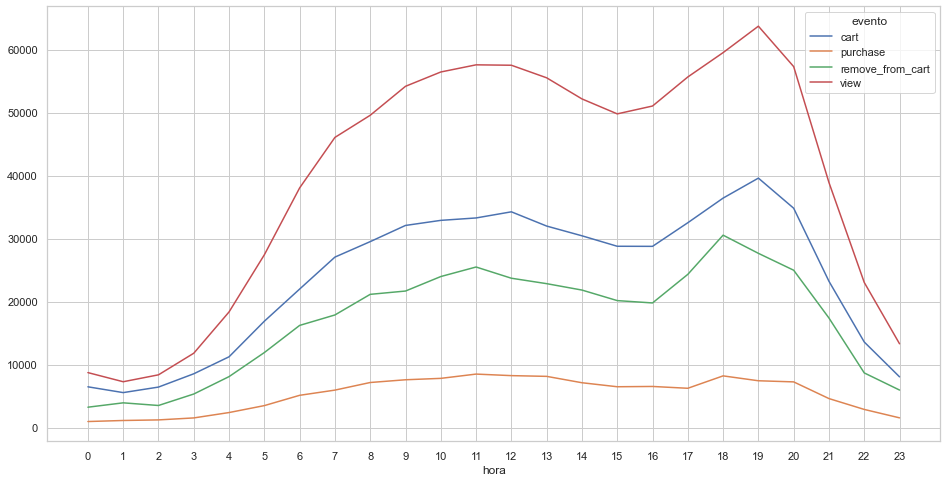

In [86]:
# Visualizamos como se distribuyen los eventos por hora

eventos_hora.plot(figsize = (16,8))
plt.xticks(ticks = eventos_hora.index);

**Observaciones del Gráfico**

Existe una pauta como era de esperar, todas incrementan o decrementan en los mísmos períodos.

Para ver mejor las diferencias podemos crear una nueva variable que sea el ratio de compras por visita en cada hora.

In [87]:
eventos_hora['compras_visitas'] = eventos_hora.purchase / eventos_hora.view * 100
eventos_hora

evento,cart,purchase,remove_from_cart,view,compras_visitas
hora,,,,,
0,6475,962,3238,8731,11.02
1,5555,1128,3930,7280,15.49
2,6433,1220,3509,8378,14.56
3,8544,1535,5331,11807,13.00
4,11242,2389,8095,18365,13.01
5,16890,3491,11913,27438,12.72
6,21993,5125,16223,38055,13.47
7,27069,5951,17883,46072,12.92
8,29526,7158,21156,49587,14.44


In [88]:
# Reordenamos variables
eventos_hora = eventos_hora[['view','cart','remove_from_cart','purchase','compras_visitas']]
eventos_hora

evento,view,cart,remove_from_cart,purchase,compras_visitas
hora,,,,,
0,8731,6475,3238,962,11.02
1,7280,5555,3930,1128,15.49
2,8378,6433,3509,1220,14.56
3,11807,8544,5331,1535,13.00
4,18365,11242,8095,2389,13.01
5,27438,16890,11913,3491,12.72
6,38055,21993,16223,5125,13.47
7,46072,27069,17883,5951,12.92
8,49587,29526,21156,7158,14.44


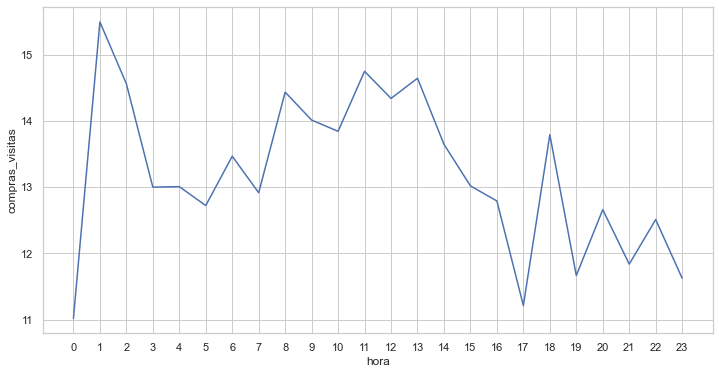

In [89]:
# Visualizamos para ver si hay horas en las que se compra proporcionalmente más.

plt.figure(figsize = (12,6))
sns.lineplot(data = eventos_hora, x = eventos_hora.index, y = 'compras_visitas')
plt.xticks(eventos_hora.index);

**Conclusiones:**

* Las horas en las que la gente compra más son la 1, las 8, de 11 a 13 y las 18
* Las horas en las que la gente no compra son las 24, de 3 a 7, de 14 a 17 y de 19 a 23

Vamos a analizar ahora no de forma proporcional, si no en absoluto si existen o no horas más frecuentes para cada tipo de evento.

In [90]:
# Observamos que las variables estan en diferentes escalas, por lo tanto hay que tipificarlas.
# Obtendremos valores comprendidos entre -3 y 3 por norma general

def tipificar(variable):
    media = variable.mean()
    dt = variable.std()
    return(variable.apply(lambda x: (x - media) / dt))

In [91]:
# Creamos df tipificado para poder visualizarlo

eventos_hora_tip = eventos_hora.apply(tipificar)
eventos_hora_tip

evento,view,cart,remove_from_cart,purchase,compras_visitas
hora,,,,,
0,-1.60,-1.56,-1.63,-1.62,-1.83
1,-1.68,-1.64,-1.54,-1.56,1.91
2,-1.62,-1.56,-1.59,-1.53,1.13
3,-1.45,-1.37,-1.38,-1.41,-0.17
4,-1.11,-1.13,-1.06,-1.09,-0.17
5,-0.65,-0.63,-0.61,-0.68,-0.41
6,-0.10,-0.17,-0.10,-0.07,0.22
7,0.31,0.28,0.09,0.24,-0.24
8,0.49,0.50,0.48,0.69,1.03


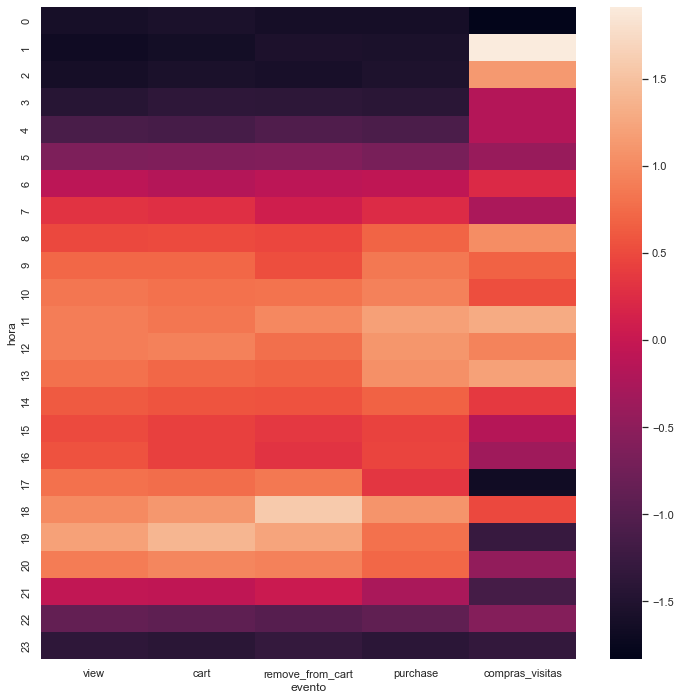

In [92]:
# Creamos un heatmap
plt.figure(figsize = (12,12))
sns.heatmap(data = eventos_hora_tip);

**Observaciones**

* Se pueden diferenciar claramente los momentos del día de mayor actividad de cada evento, cuanto más claro más actividad
* Hay que contemplar que la variable compras_vistas está en valores relativos, las demás en absolutos
* Se aprecian muchos abandonos de compra en la franja de las 18hrs.
* Hay una hora donde las compras por visita son muy rentables, y es a la 1am

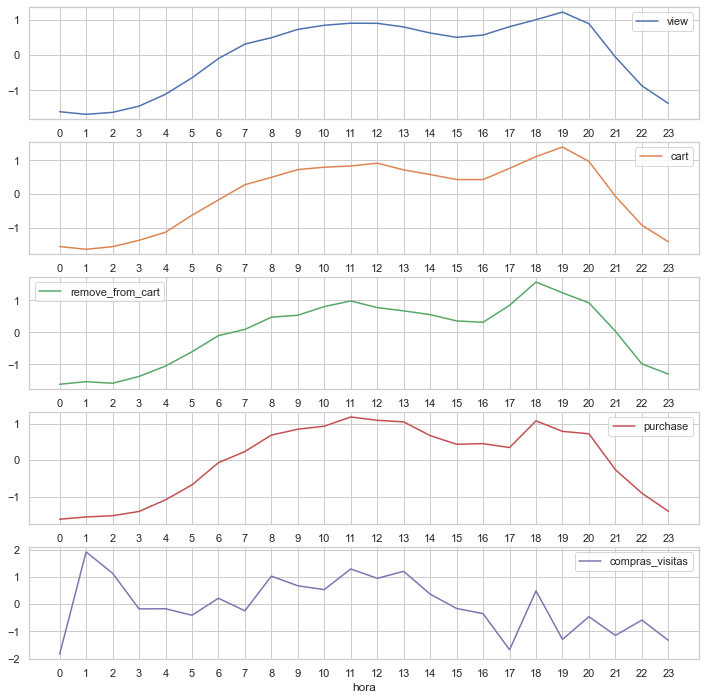

In [93]:
# Vamos a sacar tambien los graficos de lineas para verlo mas claramente

eventos_hora_tip.plot(subplots = True, sharex = False, figsize = (12,12),xticks = eventos_hora_tip.index);

**Conclusiones:**

* **INSIGHT #1:** Todas las métricas se maximzan en las franjas entre las 9 y las 13 y entre las 18 y las 20
* Esta info es muy relevante por ejemplo de cara a paid ads, tanto de generación de tráfico como de retargeting
* Parece haber algún subtipo de usuario que compra a la 1 de la mañana, que aunque no sea muy frecuente sí compra mucho

### ¿Cúal es la media de facturación mensual?

In [94]:
df.loc[df.evento == 'purchase'].groupby('mes').precio.sum().mean()

124309.92

### ¿Cúal es la tendencia en los últimos meses?

In [97]:
# Hacemos un resample a nivel semana para tener mayor número de datos, ya que sólo tenemos 5 meses

tendencia = df.groupby('evento').resample('W').evento.count().unstack(level = 0)
tendencia

evento,cart,purchase,remove_from_cart,view
fecha,,,,
2019-10-06,31483,4440,14647,36353
2019-10-13,28151,5422,17989,44410
2019-10-20,23920,5033,15303,39486
2019-10-27,25651,5665,18411,40383
2019-11-03,24087,5746,16491,39365
2019-11-10,29142,6663,24008,46177
2019-11-17,25335,5141,17215,41170
2019-11-24,38069,9754,27973,56477
2019-12-01,31994,7493,23106,48883


In [98]:
# Reordenamos las columnas

tendencia = tendencia[['view','cart','remove_from_cart','purchase']]
tendencia

evento,view,cart,remove_from_cart,purchase
fecha,,,,
2019-10-06,36353,31483,14647,4440
2019-10-13,44410,28151,17989,5422
2019-10-20,39486,23920,15303,5033
2019-10-27,40383,25651,18411,5665
2019-11-03,39365,24087,16491,5746
2019-11-10,46177,29142,24008,6663
2019-11-17,41170,25335,17215,5141
2019-11-24,56477,38069,27973,9754
2019-12-01,48883,31994,23106,7493


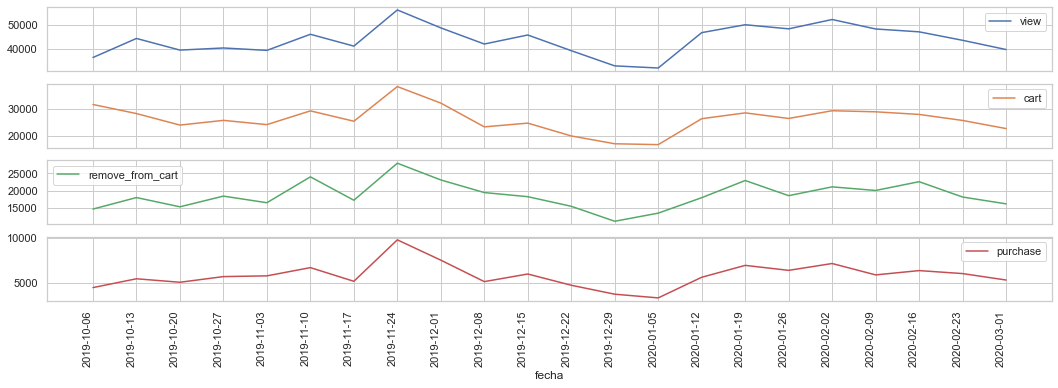

In [100]:
# Visualizamos los valores de tendencias

tendencia.plot(subplots = True, figsize = (18,6), sharex = True, xticks = tendencia.index, x_compat=True, rot = 90);

**Observaciones**

La tendencia es plana en todas las métricas, lo que confirma la necesidad de las acciones de CRO.

Existe un pico significativo en la semana del 24, obviamente por black friday, vamos a hacer el mismo análisis pero diario y solo para noviembre y dicienbre para ver el efecto.

In [101]:
# Indexamos los dos ultimos meses, agrupamos por evento y sacamos el analisis diario
tendencia_diaria = df.loc['2019-11':'2019-12'].groupby('evento').resample('D').evento.count().unstack(level = 0)
tendencia_diaria

evento,cart,purchase,remove_from_cart,view
fecha,,,,
2019-11-01,3565,709,2810,5352
2019-11-02,3015,912,2124,4857
2019-11-03,3540,755,2622,5583
2019-11-04,4652,676,4854,6248
2019-11-05,4118,753,2711,7213
...,...,...,...,...
2019-12-27,2023,507,1335,4058
2019-12-28,1744,329,1193,3704
2019-12-29,2134,263,1149,3939


In [102]:
# Renombramos columnas
tendencia_diaria = tendencia_diaria[['view','cart','remove_from_cart','purchase']]
tendencia_diaria

evento,view,cart,remove_from_cart,purchase
fecha,,,,
2019-11-01,5352,3565,2810,709
2019-11-02,4857,3015,2124,912
2019-11-03,5583,3540,2622,755
2019-11-04,6248,4652,4854,676
2019-11-05,7213,4118,2711,753
...,...,...,...,...
2019-12-27,4058,2023,1335,507
2019-12-28,3704,1744,1193,329
2019-12-29,3939,2134,1149,263


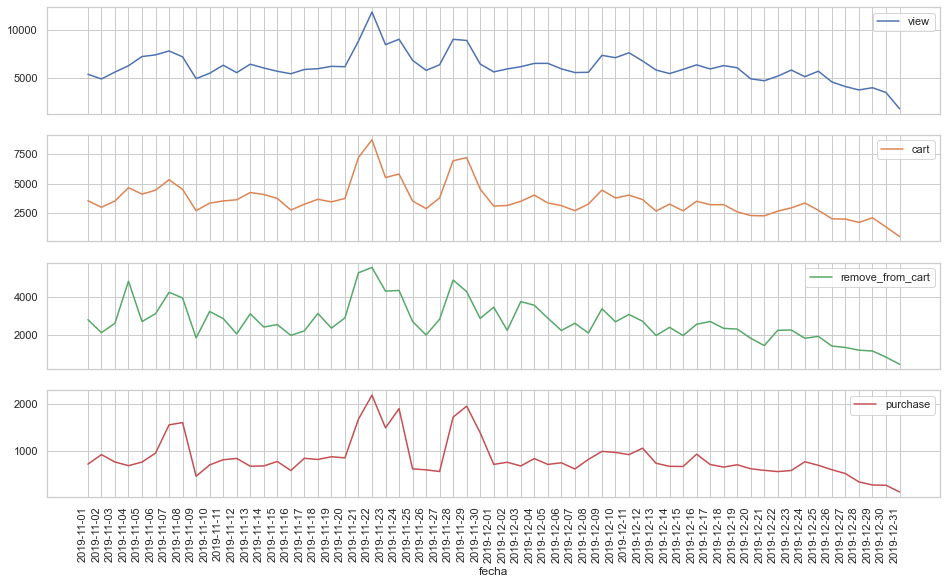

In [103]:
# Visualizamos
tendencia_diaria.plot(subplots = True, figsize = (16,10), sharex = True, xticks = tendencia_diaria.index, x_compat=True, rot = 90);

**Conclusiones:**

* Efectivamente el pico coincide con el black friday (día 29)
* Pero aún hay un pico mayor unos días antes, el día 22, posiblemente por el inicio de la semana black friday
* Sorprendemente los propios días de Navidad tienen una tendencia decreciente, lo que significa que los consumidores claramente han adelantado sus compras

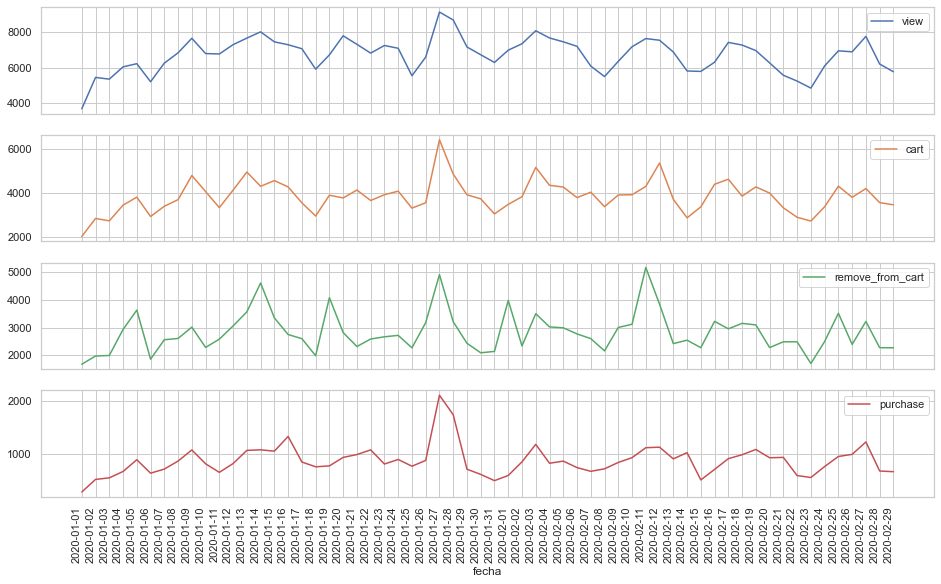

In [104]:
# Hacemos el mismo analisis pero para los meses de enero y febrero

tendencia_diaria = df.loc['2020-01':'2020-02'].groupby('evento').resample('D').evento.count().unstack(level = 0)
tendencia_diaria = tendencia_diaria[['view','cart','remove_from_cart','purchase']]
tendencia_diaria.plot(subplots = True, figsize = (16,10), sharex = True, xticks = tendencia_diaria.index, x_compat=True, rot = 90);

**Conclusiones:**

* Durante la semana de Reyes tampoco hay pico de ventas
* Ni los días previos a San Valentín
* Pero sí hay un pico muy pronunciado el 27 de Enero, seguramente algún evento local
* **INSIGHT #2** La gran conclusión es la mayor parte de facturación de las compras navideñas se reparte en la semana del black friday

### ¿Momentos de la verdad?

¿Podríamos llegar a identificar momentos a nivel de día-hora en los que se producen el mayor número de compras?

Sería muy útil para concentrar gran parte de la inversión de campañas justo en esos momentos.

In [10]:
compras_dia_hora = df.loc[df.evento == 'purchase'].groupby(['date','hora']).evento.count().unstack(level = 0).fillna(0)
compras_dia_hora

date,2019-10-01,2019-10-02,2019-10-03,2019-10-04,2019-10-05,2019-10-06,2019-10-07,2019-10-08,2019-10-09,2019-10-10,...,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29
hora,,,,,,,,,,,,,,,,,,,,,
0,13.00,18.00,1.00,2.00,0.00,0.00,0.00,0.00,3.00,23.00,...,28.00,0.00,0.00,0.00,0.00,55.00,5.00,40.00,0.00,0.00
1,0.00,0.00,5.00,0.00,4.00,24.00,3.00,0.00,16.00,0.00,...,0.00,5.00,0.00,2.00,21.00,11.00,0.00,5.00,26.00,33.00
2,0.00,0.00,0.00,24.00,0.00,0.00,0.00,18.00,4.00,18.00,...,9.00,0.00,0.00,10.00,0.00,34.00,0.00,0.00,0.00,8.00
3,0.00,24.00,10.00,0.00,0.00,26.00,2.00,20.00,16.00,55.00,...,0.00,14.00,13.00,0.00,5.00,15.00,0.00,10.00,0.00,0.00
4,15.00,0.00,45.00,27.00,3.00,24.00,12.00,46.00,56.00,0.00,...,6.00,22.00,34.00,17.00,7.00,16.00,10.00,148.00,16.00,0.00
5,49.00,9.00,6.00,17.00,1.00,14.00,21.00,10.00,0.00,43.00,...,23.00,8.00,28.00,0.00,14.00,103.00,6.00,48.00,11.00,3.00
6,23.00,34.00,18.00,10.00,10.00,13.00,38.00,35.00,14.00,12.00,...,7.00,22.00,5.00,46.00,26.00,20.00,94.00,26.00,58.00,35.00
7,26.00,60.00,26.00,54.00,58.00,20.00,63.00,27.00,26.00,59.00,...,98.00,67.00,52.00,10.00,30.00,23.00,30.00,53.00,38.00,65.00
8,28.00,71.00,129.00,49.00,20.00,37.00,27.00,41.00,89.00,62.00,...,30.00,95.00,35.00,52.00,30.00,17.00,120.00,80.00,67.00,25.00


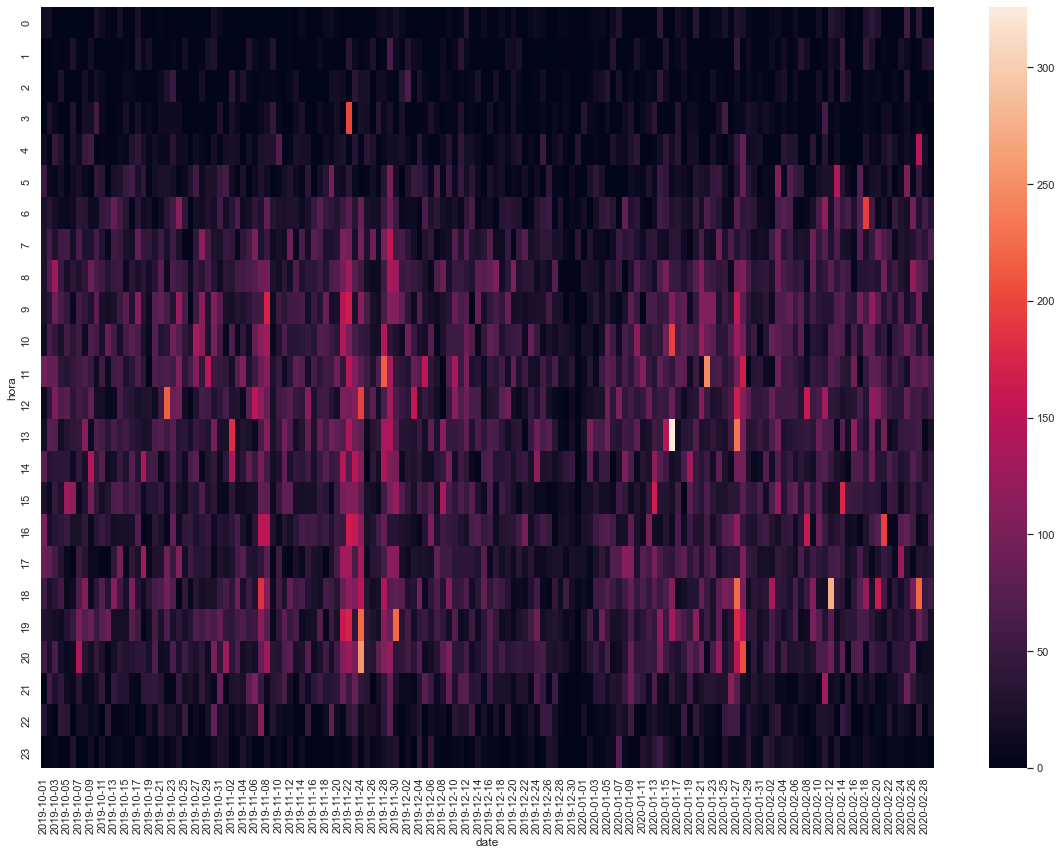

In [11]:
# Visualizamos para identificar mejor patrones

plt.figure(figsize = (20,14))
sns.heatmap(compras_dia_hora);

**Conclusión:**
Pueden apreciarse franjas horarias con mayores compras, incluso una compra muy significativa el día 17-01 a las 13hrs.
En caso de ser necesario, se podría indagar más en esta línea para establecer horarios de ads.

## Entendiendo los clientes

Para analizar a nivel de cliente lo mejor es crear un dataframe de solo compradores con granularidad cliente y las variables que nos interesan.

Hay que tener cuidado con la función de agregación que usamos en cada una.

In [12]:
clientes = df.loc[df.evento == 'purchase'].groupby(['usuario']).agg({'producto':'count',
                                                                     'sesion':'nunique', 
                                                                     'precio': 'mean',
                                                                     'date': 'max'})

clientes

,producto,sesion,precio,date
usuario,,,,
25392526,3,1,7.38,2019-12-18
27756757,1,1,20.63,2020-01-27
50748978,9,1,1.11,2019-12-14
52747911,3,1,7.67,2019-10-10
65241811,5,1,8.36,2019-11-11
...,...,...,...,...
621995551,5,1,2.09,2020-02-29
622021687,1,1,13.33,2020-02-29
622041514,3,1,0.63,2020-02-29


In [13]:
# Renombramos

clientes.columns = ['productos_tot_num','compras_tot_num','precio_medio_prod','ult_compra']
clientes

,productos_tot_num,compras_tot_num,precio_medio_prod,ult_compra
usuario,,,,
25392526,3,1,7.38,2019-12-18
27756757,1,1,20.63,2020-01-27
50748978,9,1,1.11,2019-12-14
52747911,3,1,7.67,2019-10-10
65241811,5,1,8.36,2019-11-11
...,...,...,...,...
621995551,5,1,2.09,2020-02-29
622021687,1,1,13.33,2020-02-29
622041514,3,1,0.63,2020-02-29


In [14]:
# Calculamos variables adicionales para enriquecer analisis

clientes['gasto_tot'] = clientes.productos_tot_num * clientes.precio_medio_prod
clientes['productos_por_compra'] = clientes.productos_tot_num / clientes.compras_tot_num
clientes

,productos_tot_num,compras_tot_num,precio_medio_prod,ult_compra,gasto_tot,productos_por_compra
usuario,,,,,,
25392526,3,1,7.38,2019-12-18,22.14,3.00
27756757,1,1,20.63,2020-01-27,20.63,1.00
50748978,9,1,1.11,2019-12-14,10.01,9.00
52747911,3,1,7.67,2019-10-10,23.02,3.00
65241811,5,1,8.36,2019-11-11,41.79,5.00
...,...,...,...,...,...,...
621995551,5,1,2.09,2020-02-29,10.46,5.00
622021687,1,1,13.33,2020-02-29,13.33,1.00
622041514,3,1,0.63,2020-02-29,1.90,3.00


### ¿Cómo se distribuyen los clientes en cuanto a gasto?

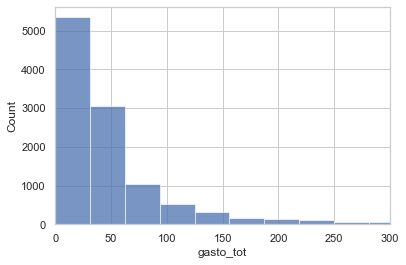

In [15]:
# Realizamos histograma, acotando el eje de gasto total y los segmentos

sns.histplot(data = clientes, x = 'gasto_tot', bins = 50)
plt.xlim([0,300]);

**Observación:**

La gran mayoría de los clientes han gastado menos de 50€ en el período.

### ¿Cómo se distribuyen los clientes en cuanto al número de compras?

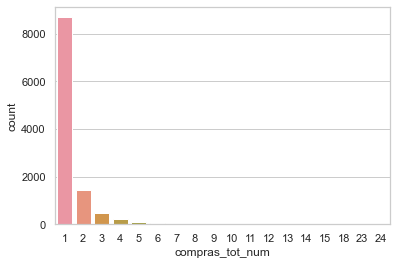

In [16]:
sns.countplot(data = clientes, x = 'compras_tot_num');

**INSIGHT #3** La gran mayoría de los clientes sólo hace una compra.

Existe gran recorrido para mejorar este ratio mediante:

email marketing con newletters y ofertas personalizadas

### ¿Cuántos productos compra un cliente de media en cada compra?

In [17]:
clientes.productos_por_compra.describe()

count          11040.00
mean               7.79
std                9.49
min                1.00
25%                3.00
50%                5.00
75%               10.00
max              219.00
Name: productos_por_compra, dtype: float64

**INSIGHT #4** La compra mediana incluye 5 productos.

Pero un 25% de los clientes compran más de 10 productos en la misma compra.

Existe gran recorrido para mejorar este ratio mediante:

sistemas de recomendación en el momento de la compra

### ¿Qué clientes nos han generado más ingresos?

In [18]:
# Seleccionamos los 10 primeros

clientes.nlargest(n = 10, columns = 'gasto_tot')

,productos_tot_num,compras_tot_num,precio_medio_prod,ult_compra,gasto_tot,productos_por_compra
usuario,,,,,,
573823111,268,2,5.82,2020-02-21,1559.21,134.00
539751397,236,13,6.16,2020-02-19,1453.37,18.15
556579890,506,4,2.75,2020-02-27,1392.45,126.50
442763940,195,8,6.37,2019-12-23,1241.53,24.38
561592095,94,3,11.81,2019-10-31,1109.70,31.33
527739278,244,13,4.39,2020-02-16,1071.00,18.77
527806771,195,13,4.86,2020-02-20,948.01,15.00
430220205,190,6,4.99,2020-02-29,947.30,31.67
491009486,219,1,4.32,2020-02-12,946.20,219.00


In [19]:
# Contrastamos calculando la media de gasto

clientes.gasto_tot.describe()

count          11040.00
mean              56.30
std               81.73
min                0.13
25%               16.22
50%               32.74
75%               60.30
max             1559.21
Name: gasto_tot, dtype: float64

**INSIGHT #5** Existen clientes con gasto medio decenas de veces superior a la media.

Hay que fidelizar estos clientes mediante programas de fidelización.

### ¿Cual es la supervivencia de los clientes?

Dado que solo tenemos 5 meses de histórico vamos a crear **análisis de cohortes** a 3 meses vista, lo cual nos da para hacer 3 cohortes.

Preparamos un dataframe solo con compradores y con las variables usuario y mes.

In [20]:
c = df.loc[df.evento == 'purchase', ['usuario','mes']]
c

,usuario,mes
fecha,,
2019-10-01 00:26:49,536128518,10
2019-10-01 00:26:49,536128518,10
2019-10-01 00:26:49,536128518,10
2019-10-01 00:26:49,536128518,10
2019-10-01 00:26:49,536128518,10
...,...,...
2020-02-29 22:29:19,622065819,2
2020-02-29 22:29:19,622065819,2
2020-02-29 22:29:19,622065819,2


In [21]:
# Pasamos los meses a columnas, creando una tabla cruzada

c = pd.crosstab(c.usuario,c.mes).reset_index()
c

mes,usuario,1,2,10,11,12
0,25392526,0,0,0,0,3
1,27756757,1,0,0,0,0
2,50748978,0,0,0,0,9
3,52747911,0,0,3,0,0
4,65241811,0,0,0,5,0
...,...,...,...,...,...,...
11035,621995551,0,5,0,0,0
11036,622021687,0,1,0,0,0
11037,622041514,0,3,0,0,0
11038,622042698,0,3,0,0,0


In [22]:
# Renombramos y eliminamos columna 'usuario' que ya no es necesaria

c.columns = ['usuario','c4','c5','c1','c2','c3']
c.drop(columns = 'usuario', inplace = True)
c

,c4,c5,c1,c2,c3
0,0,0,0,0,3
1,1,0,0,0,0
2,0,0,0,0,9
3,0,0,3,0,0
4,0,0,0,5,0
...,...,...,...,...,...
11035,0,5,0,0,0
11036,0,1,0,0,0
11037,0,3,0,0,0
11038,0,3,0,0,0


In [23]:
# La primera cohorte será la del mes 2, ya que queremos seleccionar "nuevos" clientes (al menos que no estuvieran el mes anterior)

c2 = c.loc[(c.c1 == 0) & (c.c2 > 0)]
c2

,c4,c5,c1,c2,c3
4,0,0,0,5,0
6,0,0,0,10,0
8,0,0,0,27,17
9,0,0,0,3,0
13,0,0,0,4,0
...,...,...,...,...,...
7702,0,0,0,5,0
7703,0,5,0,2,0
7705,0,0,0,1,0
7708,0,0,0,5,6


In [24]:
# Pasamos a un dataframe binario ya que solo nos importa si ese cliente ha comprado o no en cada mes.

def binarizar(variable):
    variable = variable.transform(lambda x: 1 if (x > 0) else 0)
    return(variable)

In [25]:
# Aplicamos funcion en cohorte 2
c2_b = c2.apply(binarizar)
c2_b

,c4,c5,c1,c2,c3
4,0,0,0,1,0
6,0,0,0,1,0
8,0,0,0,1,1
9,0,0,0,1,0
13,0,0,0,1,0
...,...,...,...,...,...
7702,0,0,0,1,0
7703,0,1,0,1,0
7705,0,0,0,1,0
7708,0,0,0,1,1


In [28]:
# Calcumamos el porcentaje de clientes de esta cohorte que han seguido comprando en los siguientes meses.

c2_f = c2_b.sum() / c2_b.shape[0]
c2_f = c2_f.sort_index()
c2_f

c1              0.00
c2              1.00
c3              0.10
c4              0.10
c5              0.08
dtype: float64

In [29]:
# Replicamos todo el proceso para cohorte 3

c3 = c.loc[(c.c2 == 0) & (c.c3 > 0)]
c3_b = c3.apply(binarizar)
c3_f = c3_b.sum() / c3_b.shape[0]
c3_f = c3_f.sort_index()

# Reescribimos el valor de la cohorte 1 para solo conocer los valores a partir de c3
c3_f['c1'] = 0
c3_f

c1              0.00
c2              0.00
c3              1.00
c4              0.10
c5              0.08
dtype: float64

In [30]:
# Replicamos proceso para cohorte 4

c4 = c.loc[(c.c3 == 0) & (c.c4 > 0)]
c4_b = c4.apply(binarizar)
c4_f = c4_b.sum() / c4_b.shape[0]
c4_f = c4_f.sort_index()
# Reescribimos el valor de la cohorte 1 y 2 para solo conocer los valores a partir de c4
c4_f['c1'] = 0
c4_f['c2'] = 0
c4_f

c1              0.00
c2              0.00
c3              0.00
c4              1.00
c5              0.12
dtype: float64

In [31]:
# Creamos dataframe de cohortes

cohortes = pd.DataFrame({'c2':c2_f,'c3':c3_f,'c4':c4_f})
cohortes

,c2,c3,c4
c1,0.00,0.00,0.00
c2,1.00,0.00,0.00
c3,0.10,1.00,0.00
c4,0.10,0.10,1.00
c5,0.08,0.08,0.12


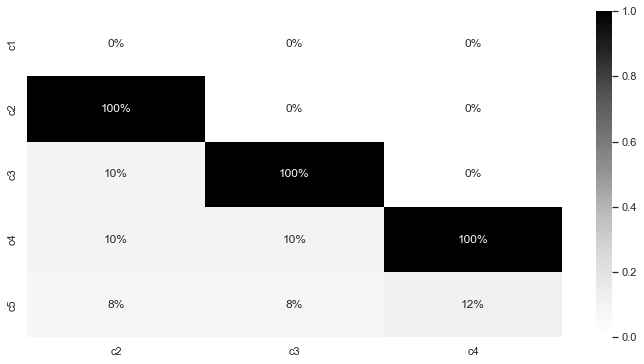

In [32]:
# Graficamos y obtenemos conclusiones
plt.figure(figsize = (12,6))
sns.heatmap(cohortes,annot = True, fmt = '.0%', cmap='Greys');

**Conclusion:**

**INSIGHT #6** El 90% de que los nuevos clientes no vuelve a comprar en los meses posteriores

### ¿Cual es el LTV de los clientes?

Teniendo en cuenta el 90% de que los nuevos clientes no vuelve a comprar en los meses posteriores podemos calcular el LTV con el histórico que tenemos sin miedo a equivocarnos mucho.

Para ello vamos a coger a los clientes de la cohorte 2 y calcular el total de sus compras.

In [33]:
# Creamos consulta para clientes  que no hayan comprado en mes 10 y si en el 11

maestro_ltv = df.loc[(df.evento == 'purchase') & (df.mes != 10) & (df.mes == 11),'usuario'].to_list()
maestro_ltv

[549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 549319657,
 566322866,
 566322866,
 566322866,
 566322866,
 566322866,
 566322866,
 566322866,
 566322866,
 491040843,
 491040843,
 491040843,
 491040843,
 491040843,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 448281768,
 483964876,
 483964876,
 483964876,
 483964876,
 483964876,
 483964876,
 483964876,
 497964079,
 497964079,
 497964079,
 497964079,
 566332999,
 551059137,
 539216862,
 539216862,
 539216862,
 539216862,
 539

In [34]:
clientes_ltv = clientes.loc[clientes.index.isin(maestro_ltv)]
clientes_ltv

,productos_tot_num,compras_tot_num,precio_medio_prod,ult_compra,gasto_tot,productos_por_compra
usuario,,,,,,
65241811,5,1,8.36,2019-11-11,41.79,5.00
80577370,10,2,10.62,2019-11-29,106.24,5.00
88211255,22,4,4.86,2020-02-25,106.87,5.50
93279832,44,2,3.19,2019-12-19,140.51,22.00
94390236,3,1,9.73,2019-11-07,29.20,3.00
...,...,...,...,...,...,...
579798049,5,1,2.10,2019-11-30,10.52,5.00
579813390,7,2,2.98,2020-02-04,20.83,3.50
579834429,1,1,27.14,2019-11-30,27.14,1.00


In [35]:
clientes_ltv.gasto_tot.describe()

count           3105.00
mean              79.62
std              113.62
min                0.13
25%               20.29
50%               41.49
75%               90.00
max             1453.37
Name: gasto_tot, dtype: float64

**Conclusiones**

Dada la variabilidad de la media sería más seguro coger la mediana.

**INSIGHT #7**: El LTV medio es de 42€.

Aplicando nuestro margen sobre esa cifra y el % que queremos dedicar a captación nos sale el importe máximo a invertir en CPA.

Aplicar las acciones de CRO permitirá incrementar el LTV y por tanto también el CPA, siendo una ventaja estratégica muy importante.

### ¿Sobre qué clientes ejecutar las próximas campañas (RFM) ?
(Recency - Frequency - Monetary)
Este análisis permite dar respuesta a necesidades como:

* Cuál es la proporción de clientes que realizan un solo pedido y clientes frecuentes
* Cuales son los clientes VIP (que potencialmente necesitan programas de fidelización y atención personalizada)
* Cuál es la cantidad de clientes nuevos (a incentivar para que vuelvan a realizar un pedido)
* Cuántos y cuáles son los clientes que no realizan compras hace tiempo
* Cuántos y cuáles son los clientes en los cuales no vale la pena invertir más tiempo y recursos
* Etc

Pasos:
1. Identificamos las variables con las que crear cada una de las dimensiones:

* **Recency**: ult_compra
* **Frequency**: compras_tot_num
* **Monetary**: gasto_tot

2. Discretizamos


In [41]:
# Creamos Frecuency:

# Los cortes de la discretizacion se generan en 5 bloques comenzando en cero, un truco es sumar 1 para que comiencen en 1

clientes['F'] = clientes.compras_tot_num.transform(lambda x: pd.cut(x,5, labels = False)) + 1
clientes

,productos_tot_num,compras_tot_num,precio_medio_prod,ult_compra,gasto_tot,productos_por_compra,F
usuario,,,,,,,
25392526,3,1,7.38,2019-12-18,22.14,3.00,1
27756757,1,1,20.63,2020-01-27,20.63,1.00,1
50748978,9,1,1.11,2019-12-14,10.01,9.00,1
52747911,3,1,7.67,2019-10-10,23.02,3.00,1
65241811,5,1,8.36,2019-11-11,41.79,5.00,1
...,...,...,...,...,...,...,...
621995551,5,1,2.09,2020-02-29,10.46,5.00,1
622021687,1,1,13.33,2020-02-29,13.33,1.00,1
622041514,3,1,0.63,2020-02-29,1.90,3.00,1


In [42]:
# Comprobamos
clientes.groupby('F').compras_tot_num.mean()

F
1              1.31
2              7.06
3             12.00
4             16.50
5             23.50
Name: compras_tot_num, dtype: float64

In [43]:
# Creamos Monetary:

clientes['M'] = clientes.gasto_tot.transform(lambda x: pd.cut(x,5, labels = False)) + 1
clientes.groupby('M').gasto_tot.mean()

M
1             48.36
2            410.98
3            765.18
4           1043.96
5           1468.34
Name: gasto_tot, dtype: float64

In [53]:
# Creamos Recency:

# Primero tenemos que transformar la fecha a un número, Ej. la distancia en días de cada fecha a la fecha más reciente disponible.

mas_reciente = clientes.ult_compra.max()

clientes['ult_compra_dias'] = clientes.ult_compra.transform(lambda x: mas_reciente - x)

clientes

,productos_tot_num,compras_tot_num,precio_medio_prod,ult_compra,gasto_tot,productos_por_compra,F,M,ult_compra_dias,R
usuario,,,,,,,,,,
25392526,3,1,7.38,2019-12-18,22.14,3.00,1,1,73 days,3
27756757,1,1,20.63,2020-01-27,20.63,1.00,1,1,33 days,2
50748978,9,1,1.11,2019-12-14,10.01,9.00,1,1,77 days,3
52747911,3,1,7.67,2019-10-10,23.02,3.00,1,1,142 days,5
65241811,5,1,8.36,2019-11-11,41.79,5.00,1,1,110 days,4
...,...,...,...,...,...,...,...,...,...,...
621995551,5,1,2.09,2020-02-29,10.46,5.00,1,1,0 days,1
622021687,1,1,13.33,2020-02-29,13.33,1.00,1,1,0 days,1
622041514,3,1,0.63,2020-02-29,1.90,3.00,1,1,0 days,1


In [54]:
# La salida que obtenemos es un timedelta, tenemos que pasarlo a numero de dias

clientes['ult_compra_dias'] = clientes.ult_compra_dias.dt.days
clientes

,productos_tot_num,compras_tot_num,precio_medio_prod,ult_compra,gasto_tot,productos_por_compra,F,M,ult_compra_dias,R
usuario,,,,,,,,,,
25392526,3,1,7.38,2019-12-18,22.14,3.00,1,1,73,3
27756757,1,1,20.63,2020-01-27,20.63,1.00,1,1,33,2
50748978,9,1,1.11,2019-12-14,10.01,9.00,1,1,77,3
52747911,3,1,7.67,2019-10-10,23.02,3.00,1,1,142,5
65241811,5,1,8.36,2019-11-11,41.79,5.00,1,1,110,4
...,...,...,...,...,...,...,...,...,...,...
621995551,5,1,2.09,2020-02-29,10.46,5.00,1,1,0,1
622021687,1,1,13.33,2020-02-29,13.33,1.00,1,1,0,1
622041514,3,1,0.63,2020-02-29,1.90,3.00,1,1,0,1


In [55]:
# Ahora si podemos crear Recency. En este caso los valores importantes son los más bajos

clientes['R'] = clientes.ult_compra_dias.transform(lambda x: pd.cut(x,5, labels = False)) + 1
clientes.groupby('R').ult_compra_dias.mean()

R
1             14.62
2             43.04
3             75.94
4            103.85
5            135.91
Name: ult_compra_dias, dtype: float64

In [56]:
# Un truco para tener todos los campos RFM de forma estandarizada es invertir éste último, restándo uno más del total

clientes['R'] = 6 - clientes.R
clientes.groupby('R').ult_compra_dias.mean()

R
1            135.91
2            103.85
3             75.94
4             43.04
5             14.62
Name: ult_compra_dias, dtype: float64

In [57]:
# Observamos dataframe
clientes.head()

,productos_tot_num,compras_tot_num,precio_medio_prod,ult_compra,gasto_tot,productos_por_compra,F,M,ult_compra_dias,R
usuario,,,,,,,,,,
25392526,3,1,7.38,2019-12-18,22.14,3.00,1,1,73,3
27756757,1,1,20.63,2020-01-27,20.63,1.00,1,1,33,4
50748978,9,1,1.11,2019-12-14,10.01,9.00,1,1,77,3
52747911,3,1,7.67,2019-10-10,23.02,3.00,1,1,142,1
65241811,5,1,8.36,2019-11-11,41.79,5.00,1,1,110,2


In [58]:
# Creamos variable con el total de los valores RFM
clientes['valor'] = clientes.R + clientes.F + clientes.M

# Creamos variable con la agrupacion de los indicadores RFM a modo codigo
clientes['RFM'] = clientes.apply(lambda x: str(x.R) + str(x.F) + str(x.M), axis = 1)
clientes

,productos_tot_num,compras_tot_num,precio_medio_prod,ult_compra,gasto_tot,productos_por_compra,F,M,ult_compra_dias,R,valor,RFM
usuario,,,,,,,,,,,,
25392526,3,1,7.38,2019-12-18,22.14,3.00,1,1,73,3,5,311
27756757,1,1,20.63,2020-01-27,20.63,1.00,1,1,33,4,6,411
50748978,9,1,1.11,2019-12-14,10.01,9.00,1,1,77,3,5,311
52747911,3,1,7.67,2019-10-10,23.02,3.00,1,1,142,1,3,111
65241811,5,1,8.36,2019-11-11,41.79,5.00,1,1,110,2,4,211
...,...,...,...,...,...,...,...,...,...,...,...,...
621995551,5,1,2.09,2020-02-29,10.46,5.00,1,1,0,5,7,511
622021687,1,1,13.33,2020-02-29,13.33,1.00,1,1,0,5,7,511
622041514,3,1,0.63,2020-02-29,1.90,3.00,1,1,0,5,7,511


In [59]:
# Creamos minicubo para obtener mayores insights

#Paso 1: Seleccionar qué variables serán la métricas y cuales las dimensiones
metricas = ['productos_tot_num','compras_tot_num','gasto_tot']
dimensiones = ['R','F','M','RFM','valor']

minicubo = clientes[dimensiones + metricas]
minicubo



,R,F,M,RFM,valor,productos_tot_num,compras_tot_num,gasto_tot
usuario,,,,,,,,
25392526,3,1,1,311,5,3,1,22.14
27756757,4,1,1,411,6,1,1,20.63
50748978,3,1,1,311,5,9,1,10.01
52747911,1,1,1,111,3,3,1,23.02
65241811,2,1,1,211,4,5,1,41.79
...,...,...,...,...,...,...,...,...
621995551,5,1,1,511,7,5,1,10.46
622021687,5,1,1,511,7,1,1,13.33
622041514,5,1,1,511,7,3,1,1.90


In [60]:
#Paso 2: pasar a transaccional las dimensiones
minicubo = minicubo.melt(id_vars = metricas)
minicubo

,productos_tot_num,compras_tot_num,gasto_tot,variable,value
0,3,1,22.14,R,3
1,1,1,20.63,R,4
2,9,1,10.01,R,3
3,3,1,23.02,R,1
4,5,1,41.79,R,2
...,...,...,...,...,...
55195,5,1,10.46,valor,7
55196,1,1,13.33,valor,7
55197,3,1,1.90,valor,7
55198,3,1,84.13,valor,7


In [61]:
#Paso 3: Agregar las métricas por "variable" y "valor" con las funciones deseadas
minicubo = minicubo.groupby(['variable','value'], as_index = False)[metricas].mean()
minicubo

,variable,value,productos_tot_num,compras_tot_num,gasto_tot
0,F,1,10.61,1.31,52.09
1,F,2,71.42,7.06,320.47
2,F,3,123.64,12.00,643.20
3,F,4,156.75,16.50,560.15
4,F,5,124.00,23.50,652.42
...,...,...,...,...,...
58,valor,9,98.02,7.25,491.71
59,valor,10,140.89,10.22,625.93
60,valor,11,291.00,5.75,1189.31
61,valor,12,189.80,16.60,833.43


In [62]:
# Analizamos Frecuency

minicubo[minicubo.variable == 'F']

,variable,value,productos_tot_num,compras_tot_num,gasto_tot
0,F,1,10.61,1.31,52.09
1,F,2,71.42,7.06,320.47
2,F,3,123.64,12.00,643.20
3,F,4,156.75,16.50,560.15
4,F,5,124.00,23.50,652.42


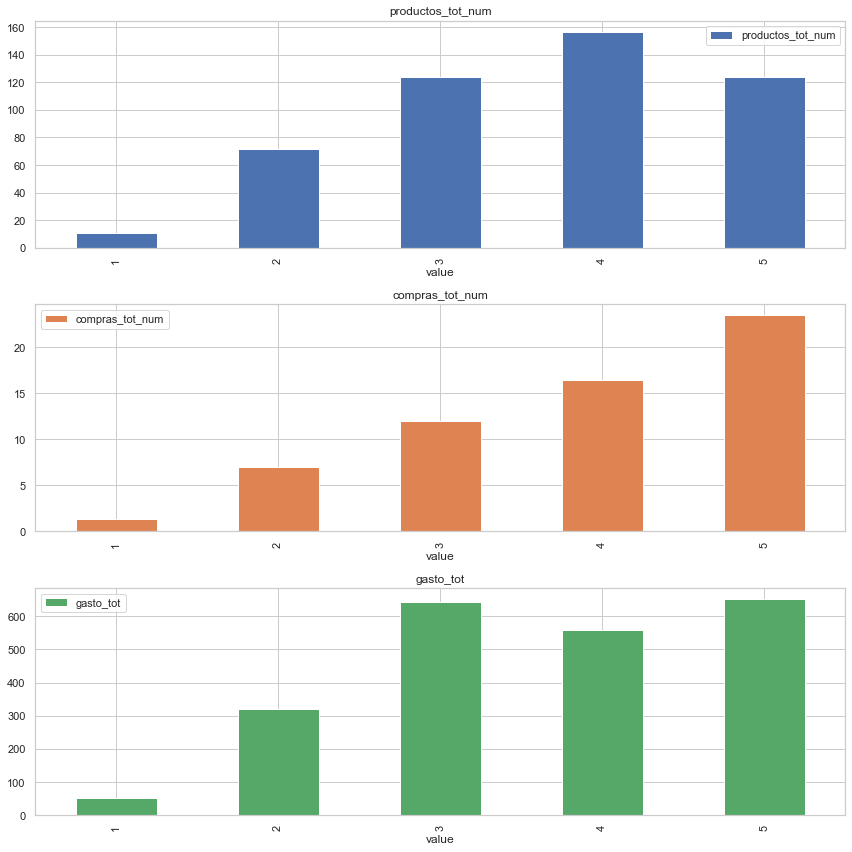

In [64]:
# Visualizamos
minicubo[minicubo.variable == 'F'].set_index('value').plot.bar(subplots = True, sharex = False, figsize = (12,12))
plt.tight_layout();

In [65]:
# Analizamos Recency

minicubo[minicubo.variable == 'R']

,variable,value,productos_tot_num,compras_tot_num,gasto_tot
10,R,1,8.15,1.08,41.56
11,R,2,9.25,1.18,45.58
12,R,3,9.54,1.29,47.25
13,R,4,11.72,1.44,58.19
14,R,5,16.83,1.82,79.04


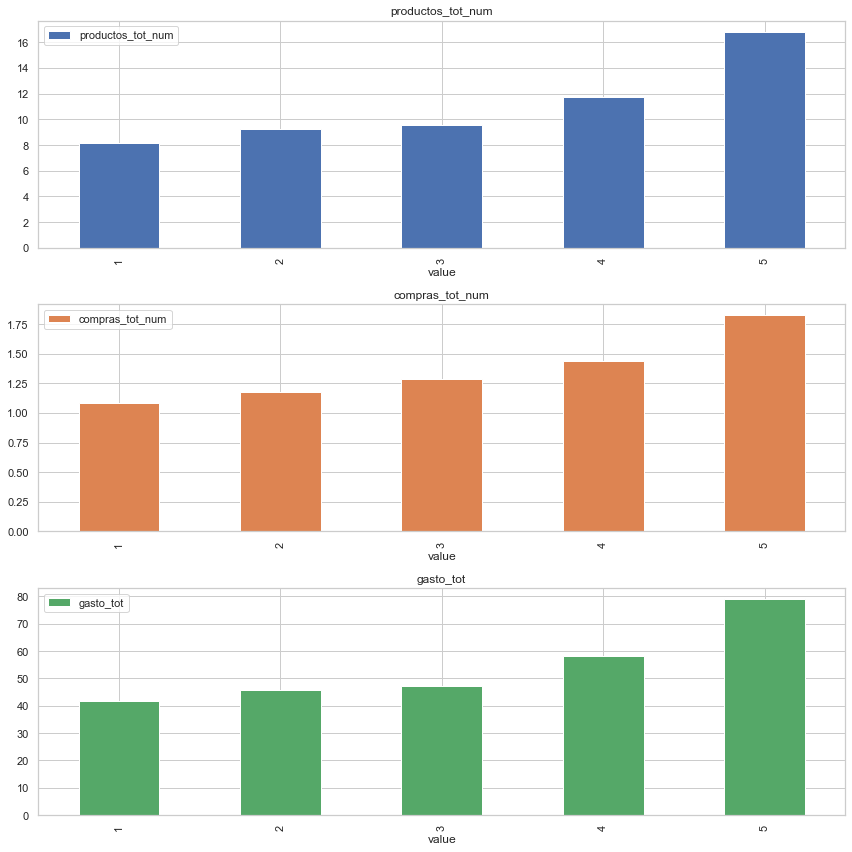

In [66]:
# Visualizamos

minicubo[minicubo.variable == 'R'].set_index('value').plot.bar(subplots = True, sharex = False, figsize = (12,12))
plt.tight_layout();

In [67]:
# Analizamos Monetary

minicubo[minicubo.variable == 'M']

,variable,value,productos_tot_num,compras_tot_num,gasto_tot
5,M,1,10.12,1.34,48.36
6,M,2,74.28,4.31,410.98
7,M,3,138.50,6.86,765.18
8,M,4,189.50,7.33,1043.96
9,M,5,336.67,6.33,1468.34


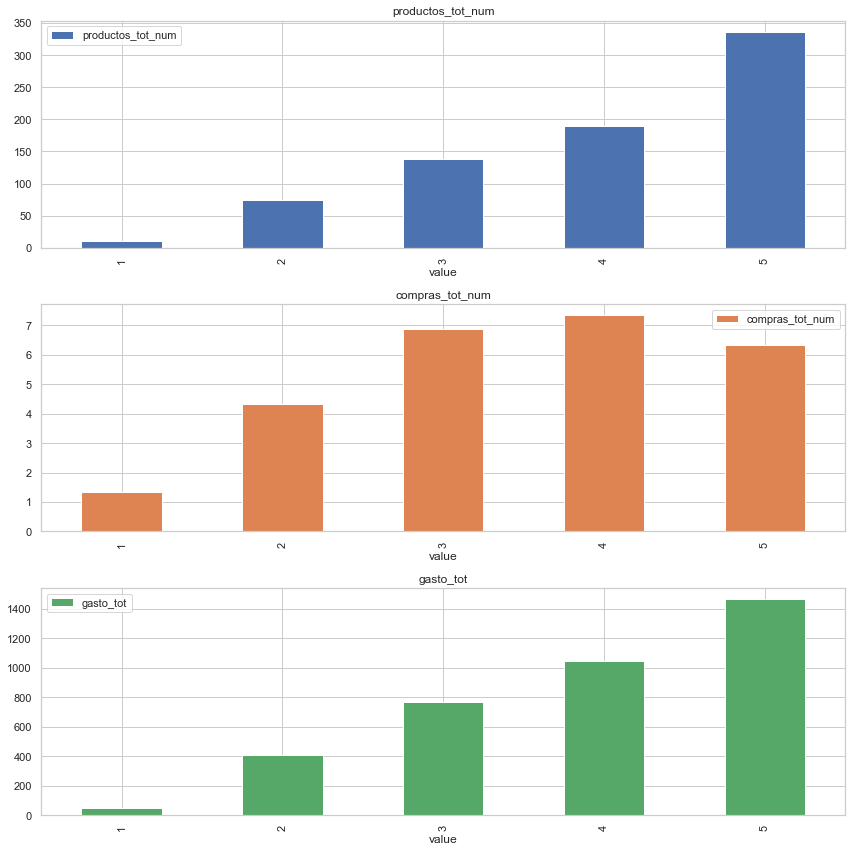

In [68]:
# Visualizamos

minicubo[minicubo.variable == 'M'].set_index('value').plot.bar(subplots = True, sharex = False, figsize = (12,12))
plt.tight_layout();

In [72]:
# Analizamos conjunto de valores RFM 'codigo'
minicubo[minicubo.variable == 'RFM']

,variable,value,productos_tot_num,compras_tot_num,gasto_tot
15,RFM,111,7.97,1.08,39.28
16,RFM,112,37.38,1.50,397.98
17,RFM,114,94.00,3.00,1109.70
18,RFM,211,8.94,1.17,43.16
19,RFM,212,47.00,1.73,391.14
20,RFM,213,35.50,1.00,662.84
21,RFM,221,85.67,6.33,194.48
22,RFM,311,8.98,1.26,43.91
23,RFM,312,53.46,2.46,376.38
24,RFM,321,39.00,6.50,141.28


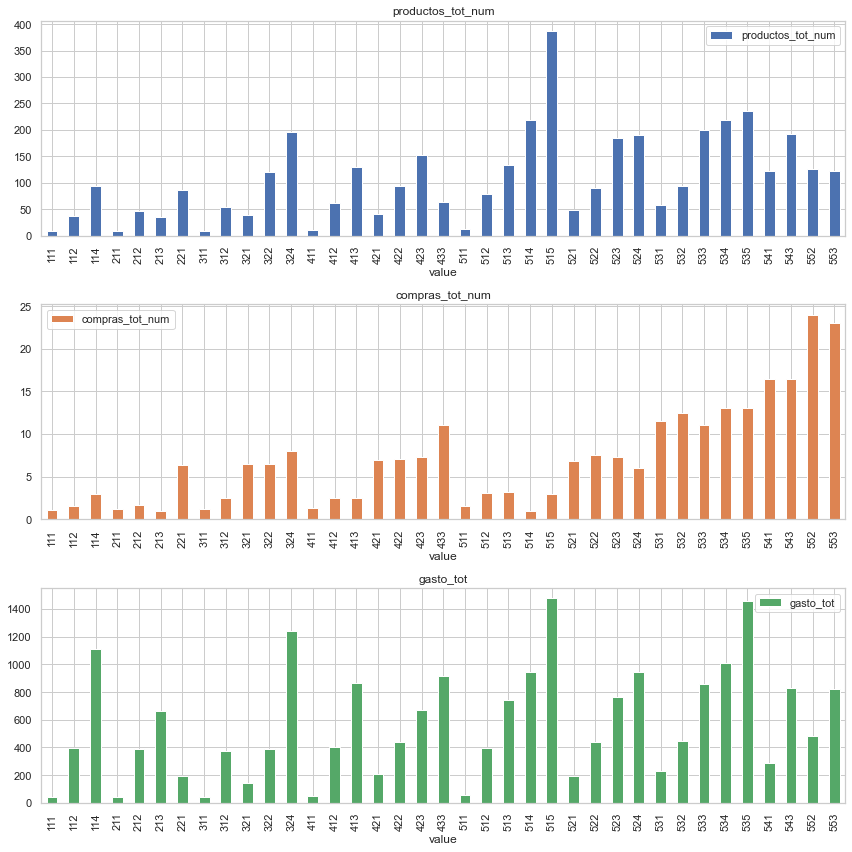

In [70]:
# Visualizamos

minicubo[minicubo.variable == 'RFM'].set_index('value').plot.bar(subplots = True, sharex = False, figsize = (12,12))
plt.tight_layout();

In [71]:
# Analizamos valor

minicubo[minicubo.variable == 'valor']

,variable,value,productos_tot_num,compras_tot_num,gasto_tot
52,valor,3,7.97,1.08,39.28
53,valor,4,9.04,1.17,44.41
54,valor,5,9.31,1.27,46.08
55,valor,6,10.73,1.38,53.07
56,valor,7,12.64,1.54,60.42
57,valor,8,66.13,5.06,313.01
58,valor,9,98.02,7.25,491.71
59,valor,10,140.89,10.22,625.93
60,valor,11,291.00,5.75,1189.31
61,valor,12,189.80,16.60,833.43


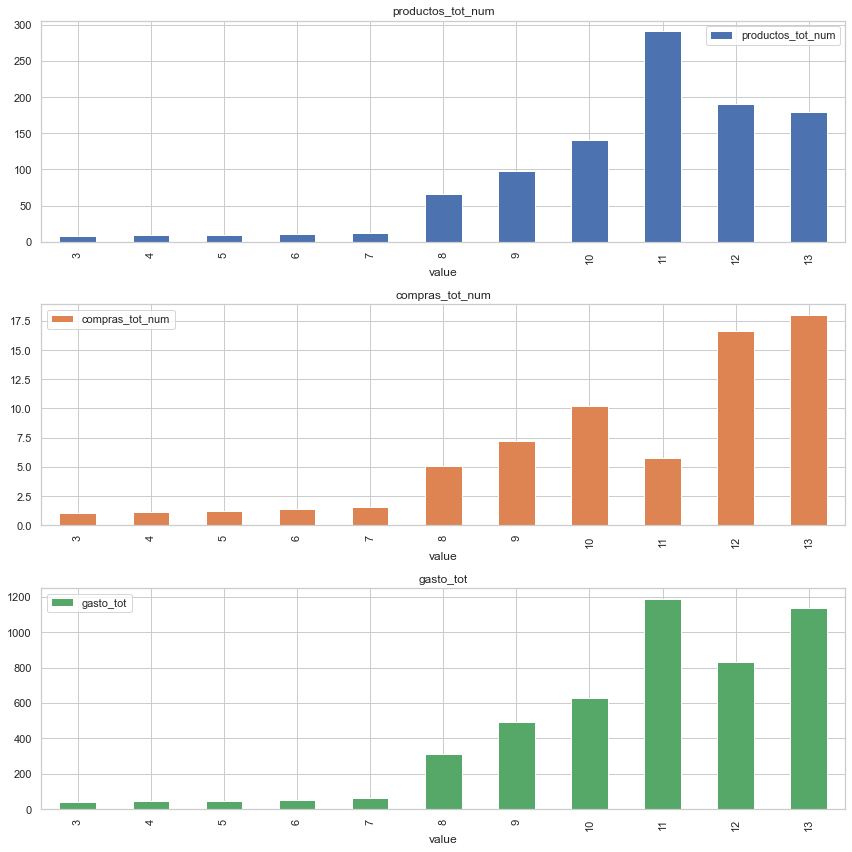

In [73]:
# Visualizamos

minicubo[minicubo.variable == 'valor'].set_index('value').plot.bar(subplots = True, sharex = False, figsize = (12,12))
plt.tight_layout();

**Observaciones**

Se podría mejorar el análisis porque en F y M los atípicos hacen que se concentren la mayoría de los datos en la categoría 1. Eliminando estos atípicos se corrige.

* A grandes rasgos, podemos identificar los clientes que con mayor probabilidad responderán mejor a nuevas campañas.

## Entendiendo los productos
Vamos a crear un dataframe a nivel de producto para poder analizar esta dimensión.



In [3]:
# Primero calculamos los conteos de cada evento en cada producto

prod = df.groupby(['producto','evento']).size()
prod

producto  evento          
3752      view                 10
3762      cart                127
          purchase             28
          remove_from_cart     59
          view                258
                             ... 
5932538   view                  1
5932540   cart                  1
          view                  2
5932578   view                  1
5932585   view                  2
Length: 137068, dtype: int64

In [4]:
# Pasamos los eventos a columnas y rellenamos nulos con cero

prod  = prod.unstack(level = 1).fillna(0)
prod

evento,cart,purchase,remove_from_cart,view
producto,,,,
3752,0.00,0.00,0.00,10.00
3762,127.00,28.00,59.00,258.00
3763,10.00,2.00,2.00,51.00
3771,0.00,0.00,0.00,9.00
3774,26.00,7.00,13.00,76.00
...,...,...,...,...
5932537,1.00,0.00,0.00,1.00
5932538,0.00,0.00,0.00,1.00
5932540,1.00,0.00,0.00,2.00


In [5]:
# Incorporamos el precio, para ello primero creamos un maestro de precios por producto

maestro_precios = df.groupby('producto', as_index = False).precio.mean()
maestro_precios

,producto,precio
0,3752,15.71
1,3762,19.29
2,3763,16.00
3,3771,15.08
4,3774,15.92
...,...,...
45322,5932537,1.43
45323,5932538,1.43
45324,5932540,1.43
45325,5932578,6.02


In [6]:
# Hacemos un left join

prod = pd.merge(left = prod, right = maestro_precios, how = 'left', on = 'producto')
prod

,producto,cart,purchase,remove_from_cart,view,precio
0,3752,0.00,0.00,0.00,10.00,15.71
1,3762,127.00,28.00,59.00,258.00,19.29
2,3763,10.00,2.00,2.00,51.00,16.00
3,3771,0.00,0.00,0.00,9.00,15.08
4,3774,26.00,7.00,13.00,76.00,15.92
...,...,...,...,...,...,...
45322,5932537,1.00,0.00,0.00,1.00,1.43
45323,5932538,0.00,0.00,0.00,1.00,1.43
45324,5932540,1.00,0.00,0.00,2.00,1.43
45325,5932578,0.00,0.00,0.00,1.00,6.02


In [7]:
# Ordenamos columnas 

prod = prod[['producto','view','cart','remove_from_cart','purchase','precio']]
prod

,producto,view,cart,remove_from_cart,purchase,precio
0,3752,10.00,0.00,0.00,0.00,15.71
1,3762,258.00,127.00,59.00,28.00,19.29
2,3763,51.00,10.00,2.00,2.00,16.00
3,3771,9.00,0.00,0.00,0.00,15.08
4,3774,76.00,26.00,13.00,7.00,15.92
...,...,...,...,...,...,...
45322,5932537,1.00,1.00,0.00,0.00,1.43
45323,5932538,1.00,0.00,0.00,0.00,1.43
45324,5932540,2.00,1.00,0.00,0.00,1.43
45325,5932578,1.00,0.00,0.00,0.00,6.02


### ¿Cuales son los productos más vendidos?

In [8]:
# Extraemos los primeros 20

prod.sort_values('purchase',ascending = False)[0:20]

,producto,view,cart,remove_from_cart,purchase,precio
16807,5809910,9195.00,2796.00,1249.00,764.00,5.21
28178,5854897,624.00,2486.00,793.00,483.00,0.32
6644,5700037,1150.00,2603.00,716.00,361.00,0.40
314,5304,516.00,1184.00,426.00,341.00,0.32
9900,5751422,2204.00,1119.00,625.00,331.00,10.87
15394,5802432,701.00,2495.00,745.00,322.00,0.32
16809,5809912,3059.00,1352.00,863.00,321.00,5.19
18415,5815662,1219.00,1697.00,653.00,310.00,0.91
9862,5751383,2341.00,1035.00,550.00,298.00,10.24
14043,5792800,1527.00,911.00,512.00,285.00,10.25


**Observación:**

Posiblemente lograríamos incrementar las ventas y el ticket medio simplemente destacando estos productos en la tienda.

###  ¿Hay productos que no se venden y podríamos eliminar del catálogo?

In [9]:
prod[prod.purchase == 0]

,producto,view,cart,remove_from_cart,purchase,precio
0,3752,10.00,0.00,0.00,0.00,15.71
3,3771,9.00,0.00,0.00,0.00,15.08
6,3790,10.00,0.00,0.00,0.00,7.92
8,3809,2.00,0.00,0.00,0.00,12.54
9,3812,1.00,0.00,0.00,0.00,12.54
...,...,...,...,...,...,...
45322,5932537,1.00,1.00,0.00,0.00,1.43
45323,5932538,1.00,0.00,0.00,0.00,1.43
45324,5932540,2.00,1.00,0.00,0.00,1.43
45325,5932578,1.00,0.00,0.00,0.00,6.02


**Conclusión**

**INSIGHT #8:** Casi la mitad de los productos no han tenido ninguna venta en los 5 meses del histórico.

Se podría comenzar todo un nuevo análisis sobre estos productos:

* ¿No se ven?
* ¿Se ven pero no se compran?
* ¿Es porque se sustituyen por otros productos propios?
* ¿Es porque están mucho más baratos en la competencia?
* Etc

Se podrían eliminar del catálogo, o como mínimo de la tienda, newsletter, etc, para que no ocupen espacio de los productos que sí se venden.

### ¿Cual es la relación entre el precio y el volumen de ventas?

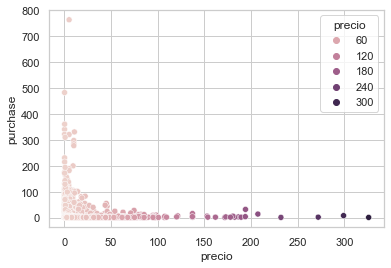

In [10]:
# Ya que este análisis incluye las ventas, vamos a eliminar los productos que no han tenido ninguna.

sns.scatterplot(data = prod[prod.purchase > 0], x = 'precio', y = 'purchase', hue = 'precio');

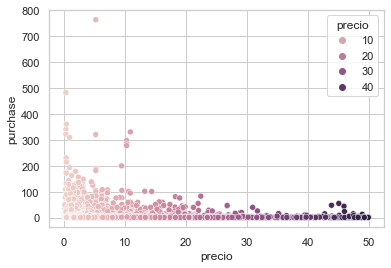

In [11]:
# Se identifica una relación decreciente
# Haremos zoom sobre los productos por debajo de 50€

sns.scatterplot(data = prod[(prod.purchase > 0) & (prod.precio < 50)], x = 'precio', y = 'purchase', hue = 'precio');

### ¿Hay productos de los que los clientes se arrepienten y eliminan más del carrito?

In [12]:
# Creamos nueva variable y la ubicamos justo en la 4 posisión con el comando insert

prod.insert(loc = 4,
            column = 'remove_from_cart_porc',
            value = prod.remove_from_cart / prod.cart *100 )
prod

,producto,view,cart,remove_from_cart,remove_from_cart_porc,purchase,precio
0,3752,10.00,0.00,0.00,NaN,0.00,15.71
1,3762,258.00,127.00,59.00,46.46,28.00,19.29
2,3763,51.00,10.00,2.00,20.00,2.00,16.00
3,3771,9.00,0.00,0.00,NaN,0.00,15.08
4,3774,76.00,26.00,13.00,50.00,7.00,15.92
...,...,...,...,...,...,...,...
45322,5932537,1.00,1.00,0.00,0.00,0.00,1.43
45323,5932538,1.00,0.00,0.00,NaN,0.00,1.43
45324,5932540,2.00,1.00,0.00,0.00,0.00,1.43
45325,5932578,1.00,0.00,0.00,NaN,0.00,6.02


In [90]:
# Para identificar los productos que más se eliminan tomamos tamaño muestral mínimo de 30

prod.loc[prod.cart > 30].sort_values('remove_from_cart_porc', ascending = False)[0:30]

,producto,view,cart,remove_from_cart,remove_from_cart_porc,purchase,precio
14330,5797131,26.00,38.00,136.00,357.89,7.00,4.43
37937,5893670,36.00,35.00,109.00,311.43,3.00,4.90
29128,5858481,41.00,31.00,64.00,206.45,7.00,4.55
16658,5809346,8.00,34.00,62.00,182.35,7.00,0.78
26120,5848412,34.00,37.00,66.00,178.38,12.00,0.79
37944,5893677,64.00,41.00,70.00,170.73,10.00,4.69
8416,5731470,39.00,34.00,58.00,170.59,10.00,6.32
3217,5635096,32.00,32.00,52.00,162.50,11.00,4.42
3244,5635127,41.00,32.00,52.00,162.50,10.00,4.43
21617,5830537,35.00,37.00,60.00,162.16,8.00,1.73


**Observaciónes**

Habría que ver por qué estos productos se eliminan más veces de las que se añaden:

* Si el motivo tiene sentido: revisar qué pasa con estos productos (otros productos alternativos, etc.)
* Si no lo tiene eliminar estos registros y analizar únicamente los que tienen remove_from_cart_porc menor o igual a 100

### ¿Cuales son los productos más vistos?

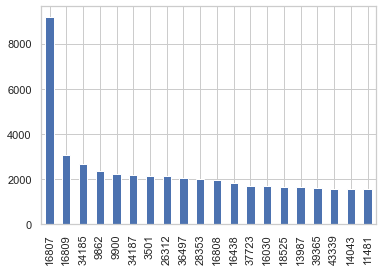

In [13]:
prod.view.sort_values(ascending = False)[0:20].plot.bar();

**Observación**

Posiblemente lograríamos incrementar las ventas y el ticket medio simplemente destacando estos productos en la tienda.

Siempre que además de ser vistos también se vendan.

### ¿Hay productos deseados pero no comprados?

Por ejemplo productos que miran muchos clientes pero que luego no los compran.

Si los encontráramos habría que revisar qué pasa con ellos.

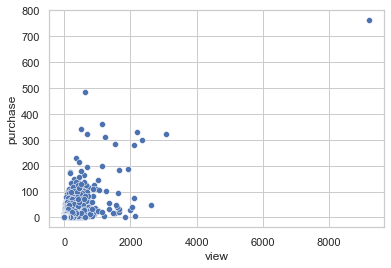

In [14]:
sns.scatterplot(data = prod, x = 'view', y = 'purchase');

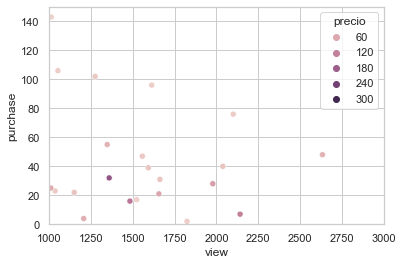

In [15]:
# Vamos a quitar el atípico y hacer zoom en la ventana de muchas vistas pocas compras.

sns.scatterplot(data = prod.loc[prod.view < 4000], x = 'view', y = 'purchase', hue = 'precio')
plt.xlim(1000,3000)
plt.ylim(0,150);

**Observación**

Hay una oportunidad con estos productos, porque por algún motivo generan el interés de los clientes, pero finalmente no los compran.

Habría que hacer un análisis sobre ellos.

### Creación de un sistema de recomendación

Desarrollaremos uno con filtrado colaborativo basado en items

#### Paso 1. Crear el dataframe con el KPI de interés:

número de veces que los productos han sido comprados por el mismo usuario.

In [16]:
# Dado que este es una algoritmo que tarda en calcularse reduciremos el problema y calculamos solo para los 100 productos más vendidos.

mas_vendidos = prod.sort_values('purchase', ascending = False).producto[0:100]
mas_vendidos

16807    5809910
28178    5854897
6644     5700037
314         5304
9900     5751422
          ...   
30395    5862564
9778     5749720
9732     5749149
22751    5835859
22116    5833335
Name: producto, Length: 100, dtype: int64

In [18]:
# Creamos df temporal filtrando estos productos

temp = df.loc[df.producto.isin(mas_vendidos)]
temp

,usuario,sesion,categoria,evento,producto,precio,date,año,mes,dia,hora,minuto,segundo,festivo,black_friday,san_valentin
fecha,,,,,,,,,,,,,,,,
2019-10-01 00:26:49,536128518,a31f0991-645e-4472-a012-95eb2f814568,1487580006317032337,purchase,5815662,0.92,2019-10-01,2019,10,1,0,26,49,0,0,0
2019-10-01 00:46:20,555415545,b9cc1771-9062-4e08-a3ad-363314cd17d8,1602943681873052386,view,5809912,5.24,2019-10-01,2019,10,1,0,46,20,0,0,0
2019-10-01 00:48:13,555415545,b9cc1771-9062-4e08-a3ad-363314cd17d8,1602943681873052386,view,5816170,5.24,2019-10-01,2019,10,1,0,48,13,0,0,0
2019-10-01 00:52:39,555415545,b9cc1771-9062-4e08-a3ad-363314cd17d8,1487580005092295511,view,5815730,10.95,2019-10-01,2019,10,1,0,52,39,0,0,0
2019-10-01 01:33:26,555456891,b3239dc3-f107-4034-a507-4c41f646e38a,1487580005092295511,view,5849033,10.32,2019-10-01,2019,10,1,1,33,26,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-29 23:11:44,615102046,17b94398-0397-4c59-bc84-fe91dde0a8ec,1487580006509970331,cart,5793703,2.22,2020-02-29,2020,2,29,23,11,44,0,0,0
2020-02-29 23:12:40,615102046,17b94398-0397-4c59-bc84-fe91dde0a8ec,2195085255034011676,cart,5550302,1.21,2020-02-29,2020,2,29,23,12,40,0,0,0
2020-02-29 23:12:50,599909613,1c6c708d-135d-487b-afa9-4bbcfd28db4d,1602943681873052386,cart,5809911,5.24,2020-02-29,2020,2,29,23,12,50,0,0,0


In [19]:
# Creamos matríz usuario/item

usuario_item = temp.loc[temp.evento == 'purchase'].groupby(['usuario','producto']).size().unstack(level = 1).fillna(0)
usuario_item

producto,4497,4600,4768,4938,4958,5013,5304,5526,5528034,5528035,...,5848909,5849033,5854812,5854897,5855332,5857007,5857360,5862564,5862943,5889300
usuario,,,,,,,,,,,,,,,,,,,,,
25392526,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50748978,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
74332980,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
80577370,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
88211255,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
621646584,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
621788730,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
621925941,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Paso 2. Reducción de la dimensionalidad

* Vemos que nos ha salido una matriz sparse.

* Posiblemente sería conveniente reducir la dimensión con técnicas como SVD, aquí vamos a continuar sin hacer la reducción.

#### Paso 3. Seleccionar una métrica de distancia

Euclidea, correlación, coceno.

In [20]:
# En este caso vamos a coger la distancia euclídea.

# La operativizamos mediante la función spatial.distance.euclidean de Scipy.

from scipy import spatial

#### Paso 4. Calcular la matriz item-item

Creamos el recomendador que toma como input una matriz usuario-item y devuelve una matriz item-item con la distancia euclídea como dato.

In [21]:
# Definimos función de distancia dentro de otra función

def recomendador(dataframe):

    def distancia(producto):
        return(dataframe.apply(lambda x: spatial.distance.euclidean(x,producto)))

    return(dataframe.apply(lambda x: distancia(x)))

In [22]:
# Aplicamos función y creamos matriz

item_item = recomendador(usuario_item)
item_item

producto,4497,4600,4768,4938,4958,5013,5304,5526,5528034,5528035,...,5848909,5849033,5854812,5854897,5855332,5857007,5857360,5862564,5862943,5889300
producto,,,,,,,,,,,,,,,,,,,,,
4497,0.00,14.42,14.49,15.62,15.91,17.58,23.39,15.23,16.16,20.30,...,15.72,24.45,14.97,26.10,15.30,15.07,15.78,15.17,16.40,15.33
4600,14.42,0.00,10.68,14.49,14.59,16.46,22.69,13.93,14.87,19.70,...,14.39,23.87,13.49,25.75,13.78,13.60,14.46,13.86,14.73,13.89
4768,14.49,10.68,0.00,14.56,14.73,16.28,22.74,14.00,14.93,19.75,...,14.18,24.00,13.27,25.63,13.86,13.75,14.39,13.86,14.80,14.11
4938,15.62,14.49,14.56,0.00,15.52,16.03,22.96,14.76,15.65,20.25,...,15.13,24.17,14.35,25.87,14.76,14.59,15.46,14.97,15.72,15.13
4958,15.91,14.59,14.73,15.52,0.00,17.49,22.27,15.33,15.81,20.32,...,15.49,24.35,14.66,26.15,14.87,14.97,15.94,15.26,16.12,15.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5857007,15.07,13.60,13.75,14.59,14.97,16.79,22.80,14.59,15.10,19.62,...,14.49,23.98,13.89,25.61,14.32,0.00,14.83,14.46,15.17,14.42
5857360,15.78,14.46,14.39,15.46,15.94,16.06,23.24,15.39,16.12,20.32,...,15.43,23.85,14.73,25.46,15.20,14.83,0.00,13.75,16.19,15.43
5862564,15.17,13.86,13.86,14.97,15.26,15.72,22.91,14.70,15.39,19.90,...,15.00,23.32,14.00,25.12,14.35,14.46,13.75,0.00,15.39,14.66


#### Paso 5. Crear la lógica de priorización

Ya tenemos listo el recomendador.

Lo que tendríamos que hacer es una llamada a esta tabla cada vez que un usuario mire un producto o lo meta en el carrito.

Pero para que sea más efectivo podríamos usar toda la info acumulada de la sesión o incluso de todo el usuario si está logado.

Eso significa que necesitamos un sistema para recomendar productos tanto si el input es de un solo producto como de varios.

Y que a la vez devuelva varias recomendaciones, para cubrir todos los "huecos" de recomendación que nuestra web pudiera tener.

Aplicaremos un algoritmo muy sencillo que hará:

* Crear un array con los productos de entrada para extraer sus vectores de la matriz item-item
* Calcular la suma de distancias de todos los productos
* Quitarse a ellos mismos para no autorecomendarse.
* Devolver los 10 con menor distancia

In [26]:
#En el caso de varios productos vendrá del servidor web como una cadena separada con punto y coma

def priorizador(productos,devuelve = 10):
    #crear array con productos de entrada
    array = np.int64(productos.split(';'))
    
    #extraer sus vectores de la matriz total
    matriz = item_item[array]
    
    #calcular la suma de distancias
    suma_distancias = matriz.agg(sum,axis = 1)
    
    #eliminar los productos input
    suma_distancias = suma_distancias.loc[~suma_distancias.index.isin(list(array))]
    
    #Devolver los 10 con menor distancia
    return(suma_distancias.sort_values()[0:devuelve])

In [28]:
# Comprobamos funcionamiento pasando unos productos de ejemplo

priorizador('4768;5857007')

producto
4600                24.28
5833335             26.26
5749149             26.34
5833318             26.42
5809303             26.64
5835859             26.72
5724230             26.94
5816169             27.01
5824810             27.01
5550302             27.02
dtype: float64

# Conclusiones

La tendencia actual es plana en todas las métricas, lo que confirma la necesidad de las acciones de CRO.

Tras el análisis realizado sobre los datos transaccionales se ha desarrollado un plan CRO de 12 iniciativas concretas organizadas en 5 grandes palancas de negocio que con alta probabilidad van a incrementar los baselines consiguiendo un incremento global de los ingresos del ecommerce.

## Baseline

En cada sesión, de media:

* KPIs por sesión: Se ven 2.2 productos
* KPIs por sesión: Se añaden 1.3 productos al carrito
* KPIs por sesión: Se eliminan 0.9 productos del carrito
* KPIs por sesión: Se compran 0.3 productos
* Venta cruzada: mediana de 5 productos por compra
* Recurrencia: el 10% de los clientes vuelve a comprar tras el primer mes
* Conversión: 60% de añadir al carrito sobre visualizaciones
* Conversión: 22% de compra sobre añadidos a carrito
* Conversión: 13% de compra sobre visualizaciones
* Facturación media mensual: 125.000€

## Acciones de incrementos de visualizaciones

1. Revisar las campañas de paid (generación y retargeting) para concentrar la inversión en franjas entre las 9 y las 13 y entre las 18 y las 20
2. Concentrar la inversión del período navideño y post-navideño en la semana del black friday
3. Incrementar la inversión hasta llegar al CPA máximo en base al LTV que hemos identificado

## Acciones e incremento de conversión

4. Preconfigurar la home con los productos identificados en los análisis most viewed y most sold.
5. Trabajar sobre los productos con alta tasa de abandono de carrito
6. Trabajar sobre los productos muy vistos pero poco comprados

## Acciones de incremento de venta cruzada

7. La compra mediana incluye 5 productos
8. Incrementar este ratio mediante la recomendación en tiempo real con el nuevo recomendado

## Acciones de incremento de frecuencia de compra

9. El 90% de los clientes sólo hace una compra
10. Crear una newsletter periódica con el nuevo recomendador para incrementar la frecuencia de visita
11. Campañas promocionales sobre los segmentos top de la segmentación RFM

## Acciones de fidelización de clientes

12. Crear un programa de fidelización segmentado por la nueva segmentación RFM